In [927]:
import pandas as pd
import requests
from urllib.parse import urlencode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import pylab as py
from scipy.stats import percentileofscore
import calendar
from datetime import timedelta
import statistics
import datetime as dt

In [928]:
sns.set(          # настройка размера графика в Jupyter
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(10,5)}
        )

# Загрузка данных из условия

### Загрузка таблицы с уникальными идентификаторами пользователей

In [929]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
customers_key = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg' # ссылка на данные с уникальными идентификаторами пользователей

In [930]:
# получаем url 
final_url = base_url + urlencode(dict(public_key=customers_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

In [931]:
# загружаем файл в df 
download_response = requests.get(download_url) 
df_customers = pd.read_csv(download_url) 

In [932]:
#df_customers = pd.read_csv('/home/anton23/Downloads/Telegram Desktop/olist_customers_dataset.csv')

### Таблица с уникальными идентификаторами пользователей

In [933]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Из условия:

customer_id — позаказный идентификатор пользователя

customer_unique_id — уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix — почтовый индекс пользователя

customer_city — город доставки пользователя

customer_state — штат доставки пользователя

In [934]:
df_customers.shape

(99441, 5)

In [935]:
df_customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [936]:
df_customers.isna().values.any() # проводим проверку на пропущенные значения

False

In [937]:
df_customers.customer_id.nunique()

99441

Количество уникальных значений в колонке customer_id совпадает с количеством строк таблицы, значит данная колонка состоит только из уникальных значений.

In [938]:
df_customers.customer_unique_id.nunique()

96096

In [939]:
df_customers.customer_unique_id.duplicated().any()

True

Как видим, в колонке customer_unique_id есть повторяющиеся значения.

In [940]:
print(df_customers.customer_state.unique()) # штаты доставки пользователя

['SP' 'SC' 'MG' 'PR' 'RJ' 'RS' 'PA' 'GO' 'ES' 'BA' 'MA' 'MS' 'CE' 'DF'
 'RN' 'PE' 'MT' 'AM' 'AP' 'AL' 'RO' 'PB' 'TO' 'PI' 'AC' 'SE' 'RR']


In [941]:
df_customers.customer_city.nunique() # количество уникальных городов доставки пользователя

4119

### Загрузка таблицы заказов

In [942]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
orders_key = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw' # ссылка на данные заказов

In [943]:
# получаем url 
final_url = base_url + urlencode(dict(public_key=orders_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

In [944]:
# загружаем файл в df 
download_response = requests.get(download_url) 
df_orders = pd.read_csv(download_url) 

In [945]:
#df_orders = pd.read_csv('/home/anton23/Downloads/Telegram Desktop/olist_orders_dataset.csv')

### Таблица заказов

In [946]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Из условия:
    
order_id — уникальный идентификатор заказа (номер чека)

customer_id — позаказный идентификатор пользователя

order_status — статус заказа

order_purchase_timestamp — время создания заказа

order_approved_at — время подтверждения оплаты заказа

order_delivered_carrier_date — время передачи заказа в логистическую службу

order_delivered_customer_date — время доставки заказа

order_estimated_delivery_date — обещанная дата доставки

In [947]:
df_orders.shape

(99441, 8)

Обратим внимание, что количество строк в df_orders совпадает с количеством строк таблицы df_customers

In [948]:
df_orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

Видим, что во всех колонках с датами содержатся значения типа данных string. Приведём значения в колонках с датами к типу данных datetime64[ns].

In [949]:
columns_to_datetime = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                       'order_delivered_customer_date', 'order_estimated_delivery_date']
df_orders[columns_to_datetime] = df_orders[columns_to_datetime].apply(pd.to_datetime)

In [950]:
df_orders.dtypes # Убедимся, что тип данных колонок с датами изменился

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [951]:
df_orders.isna().values.any() # проводим проверку на пропущенные значения

True

Как видим, в данной таблице есть пропущенные значения. Рассмотрим подробнее, где именно значения пропущены.

In [952]:
df_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

По условию <br> order_approved_at — время подтверждения оплаты заказа <br> order_delivered_carrier_date — время передачи заказа в логистическую службу <br> order_delivered_customer_date — время доставки заказа <br> Логично, что в данных колонках могут быть пропуски, так как оплата может не подтвердиться, заказ может быть не переданным в логическую службу или быть не доставленным до покупателя. Следовательно, на данном этапе не стоит удалять строки с пропущенными значениями. Рассмотрим данные строки подробнее позже на этапе определения покупки.

In [953]:
df_orders.order_id.nunique()

99441

In [954]:
df_orders.customer_id.nunique()

99441

Колонки order_id и customer_id состоят только из уникальных значений (Количество уникальных значений совпадает с количеством строк в таблице)

In [955]:
print(df_orders.order_status.unique()) # уникальные статусы заказов

['delivered' 'invoiced' 'shipped' 'processing' 'unavailable' 'canceled'
 'created' 'approved']


### Загрузка таблицы с товарными позициями, входящими в заказы

In [956]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
items_key = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg' # ссылка на данные с позициями

In [957]:
# получаем url 
final_url = base_url + urlencode(dict(public_key=items_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

In [958]:
# загружаем файл в df 
download_response = requests.get(download_url)
df_items = pd.read_csv(download_url)

In [959]:
#df_items = pd.read_csv('/home/anton23/Downloads/Telegram Desktop/olist_order_items_dataset.csv')

### Таблица с товарными позициями, входящими в заказы

In [960]:
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Из условия:
    
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

In [961]:
df_items.shape

(112650, 7)

In [962]:
df_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

Колонка shipping_limit_date даты типа данных string. Приведём значения данной колонки к типу данных datetime64[ns].

In [963]:
df_items['shipping_limit_date'] = pd.to_datetime(df_items['shipping_limit_date'])

In [964]:
df_items.dtypes # Убедимся, что тип данных колонки shipping_limit_date изменился

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [965]:
df_items.isna().values.any() # проводим проверку на пропущенные значения

False

В данной таблице пропущенных значений нет

In [966]:
df_items.order_id.nunique()

98666

В данной таблице уникальных значений в колонке order_id меньше (98666), чем в аналогичной колонке в предыдущих таблицах (99441) 

In [967]:
df_items.product_id.nunique() # количество уникальных товаров, входящих в заказы

32951

In [968]:
df_items.seller_id.nunique() # количество уникальных продавцов

3095

In [969]:
print(df_items.order_item_id.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


Можно увидеть, что максимально 21 товар может входить в один заказ

In [970]:
df_items.price.describe()

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

Можно сделать вывод, что бесплатных товаров нет.

In [971]:
df_items.freight_value.describe()

count    112650.000000
mean         19.990320
std          15.806405
min           0.000000
25%          13.080000
50%          16.260000
75%          21.150000
max         409.680000
Name: freight_value, dtype: float64

Можно сделать вывод, что были товары, вес которых равен 0. Рассмотрим подробнее данные товары.

In [972]:
df_items.query("freight_value == 0").head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
114,00404fa7a687c8c44ca69d42695aae73,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-15 04:31:26,99.9,0.0
258,00a870c6c06346e85335524935c600c0,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-05-14 00:14:29,69.9,0.0
483,011c899816ea29773525bd3322dbb6aa,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,2018-05-07 05:30:45,99.9,0.0
508,012b3f6ab7776a8ab3443a4ad7bef2e6,1,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0
509,012b3f6ab7776a8ab3443a4ad7bef2e6,2,422879e10f46682990de24d770e7f83d,1f50f920176fa81dab994f9023523100,2018-05-09 21:30:50,53.9,0.0


In [973]:
df_items.query("freight_value == 0").shape

(383, 7)

Есть 383 товара, вес которых равен 0.

# Определение заказов, являющихся покупками

Для определения заказов, являющихся покупками, рассмотрим подробнее таблицы df_orders и df_items, так как df_orders содержит всю информацию о заказах, а df_items содержить всю информацию о товарах, входящих в заказы.

In [974]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [975]:
print(df_orders.order_status.unique()) # уникальные статусы заказов

['delivered' 'invoiced' 'shipped' 'processing' 'unavailable' 'canceled'
 'created' 'approved']


Из условия:
<ul>
<li>created —  создан</li>
<li>approved —  подтверждён</li>
<li>invoiced —  выставлен счёт</li>
<li>processing —  в процессе сборки заказа</li>
<li>shipped —  отгружен со склада</li>
<li>delivered —  доставлен пользователю</li>
<li>unavailable —  недоступен</li>
<li>canceled —  отменён</li>
</ul>

In [976]:
df_orders.order_status.value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Рассмотрим подробнее каждый статус

### Заказы со статусом created

In [977]:
df_orders.query("order_status == 'created'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
7434,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11
9238,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07
21441,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12
55086,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08
58958,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01


Всего 6 заказов со статусом created, при этом у данных заказов колонки order_approved_at, order_delivered_carrier_date, order_delivered_customer_date не заполнены. Значит, оплата данных заказов не подтверждена, данные заказы не были переданы в логистическую службу и не были доставлены до пользователя.

Проверим наличие заказов со статусом created в таблице df_items (таблица с товарными позициями, входящими в заказы)

In [978]:
df_items['order_id'].isin(df_orders.query("order_status == 'created'").order_id).any()

False

Заказы со статусом created в таблице df_items отсутствуют

### Заказы со статусом approved

In [979]:
df_orders.query("order_status == 'approved'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
44897,a2e4c44360b4a57bdff22f3a4630c173,8886130db0ea6e9e70ba0b03d7c0d286,approved,2017-02-06 20:18:17,2017-02-06 20:30:19,NaT,NaT,2017-03-01
88457,132f1e724165a07f6362532bfb97486e,b2191912d8ad6eac2e4dc3b6e1459515,approved,2017-04-25 01:25:34,2017-04-30 20:32:41,NaT,NaT,2017-05-22


Всего 2 заказа со статусом approved, при этом у данных заказов колонки order_delivered_carrier_date, order_delivered_customer_date не заполнены. Значит, оплата данных заказов подтверждена, но они не были переданы в логистическую службу и не были
доставлены до пользователя.

Можно понять, что данные заказы оносятся к 2017 году.

Проверим наличие заказов со статусом approved в таблице df_items (таблица с товарными позициями, входящими в заказы)

In [980]:
df_items['order_id'].isin(df_orders.query("order_status == 'approved'").order_id).any()

True

In [981]:
df_items.loc[df_items['order_id'].isin(df_orders.query("order_status == 'approved'").order_id)]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
8409,132f1e724165a07f6362532bfb97486e,1,c4a1c4638fa9e2e4861d141d6e0259e7,5444b12c82f21c923f2639ebc722c1ea,2017-05-08 20:32:41,169.90,9.56
71423,a2e4c44360b4a57bdff22f3a4630c173,1,dcecb611ba878d5d8c7853585b285c12,8cc6a0e5738e61a87b03c78b2ba9db4b,2017-02-10 20:18:17,19.85,10.96
71424,a2e4c44360b4a57bdff22f3a4630c173,2,dcecb611ba878d5d8c7853585b285c12,8cc6a0e5738e61a87b03c78b2ba9db4b,2017-02-10 20:18:17,19.85,10.96


Все заказы со статусом approved есть в таблице df_items

### Заказы со статусом invoiced

In [982]:
df_orders.query("order_status == 'invoiced'").sort_values('order_approved_at', ascending=False).head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
56185,c3fd18a4aeb8e2d589b0248ce60e91b7,17c867817e32d1474241a11bb120d4c4,invoiced,2018-08-14 18:45:08,2018-08-14 19:05:23,NaT,NaT,2018-08-27
82498,67d06af97696c95df2bb26acf82db637,d3ddbbd220a088a3e353cd270c184e60,invoiced,2018-08-09 17:18:57,2018-08-09 17:50:12,NaT,NaT,2018-08-17
35918,a03ac1d748cc1533566bf2c8199159d4,d89f76444e908c953bd1f8390aec9a00,invoiced,2018-08-09 06:43:29,2018-08-09 06:55:06,NaT,NaT,2018-08-24
81153,7737b48ac906ed0be3c192bb1fc4c4ef,710f79302fb4b836681bfd921167167b,invoiced,2018-08-07 09:48:08,2018-08-08 08:50:20,NaT,NaT,2018-08-14
83970,eb4d645f0a565f91e489a626b9b22334,4cf76a034161c9ca5e11089c3771c439,invoiced,2018-08-07 13:47:04,2018-08-08 07:10:13,NaT,NaT,2018-08-13


In [983]:
df_orders.query("order_status == 'invoiced'").shape # количество строк = количество заказов с данным статусом

(314, 8)

In [984]:
df_orders.query("order_status == 'invoiced'").isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     314
order_delivered_customer_date    314
order_estimated_delivery_date      0
dtype: int64

Всего 314 заказов со статусом invoiced. У данных заказов, как и у заказов со статусом approved, колонки order_delivered_carrier_date, order_delivered_customer_date не заполнены. Значит, оплата данных заказов подтверждена, но они не были переданы в логистическую службу и не были доставлены до пользователя.

Проверим наличие заказов со статусом invoiced в таблице df_items (таблица с товарными позициями, входящими в заказы)

In [985]:
df_items['order_id'].isin(df_orders.query("order_status == 'invoiced'").order_id).any()

True

In [986]:
df_items.loc[df_items['order_id'].isin(df_orders.query("order_status == 'invoiced'").order_id)].head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
590,015fb6b5f739788434fa690540f90f19,1,a0eccc912d428eaddf1ef4fe47593ece,8a87611c08849ffeeccab52aa798b6c7,2017-02-04 13:06:05,143.00,94.98
591,015fb6b5f739788434fa690540f90f19,2,a0eccc912d428eaddf1ef4fe47593ece,8a87611c08849ffeeccab52aa798b6c7,2017-02-04 13:06:05,143.00,94.98
913,021dac6e3120485db6a77474aa21b979,1,7535f3518e1009b17aa6e3fa553e82bc,8b87cd0d43d49b9bdf40f56229364d59,2017-11-30 01:53:42,479.00,55.36
1138,02a0eb7c22b0616c767a45954a2a28f6,1,5f8c74f4a3d2b616857fcb7d4dd1f61a,83e197e95a1bbabc8c75e883ed016c47,2016-10-14 08:14:53,119.50,25.04
1460,035b790fa740b68de2d6f1a74f9b2098,1,cf18e908cb8600dcd21a719db24c48d8,7ddcbb64b5bc1ef36ca8c151f6ec77df,2018-03-29 18:48:01,63.99,8.29


In [987]:
df_items.loc[df_items['order_id'].isin(df_orders.query("order_status == 'invoiced'").order_id)].order_id.nunique()

312

Не все заказы со статусом invoiced есть в таблице df_items (не хватает 2 заказов)

Рассмотрим, каких именно заказов нет.

In [988]:
df_orders.query("order_status == 'invoiced'").loc[~df_orders['order_id'].isin(df_items['order_id'])]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
57591,2ce9683175cdab7d1c95bcbb3e36f478,b2d7ae0415dbbca535b5f7b38056dd1f,invoiced,2016-10-05 21:03:33,2016-10-06 07:46:39,NaT,NaT,2016-11-25
69926,e04f1da1f48bf2bbffcf57b9824f76e1,0d00d77134cae4c58695086ad8d85100,invoiced,2016-10-05 13:22:20,2016-10-06 15:51:38,NaT,NaT,2016-11-29


Рассмотрим минимальные значения df_orders для заказов со статусом invoiced

In [989]:
df_orders.query("order_status == 'invoiced'").min()

order_id                         015fb6b5f739788434fa690540f90f19
customer_id                      01950e4d4d0f0f8561e721ad5c8b0f9a
order_status                                             invoiced
order_purchase_timestamp                      2016-10-04 13:02:10
order_approved_at                             2016-10-04 14:08:38
order_delivered_carrier_date                                  NaT
order_delivered_customer_date                                 NaT
order_estimated_delivery_date                 2016-11-24 00:00:00
dtype: object

Видим, что у данных заказов нет минимальных значений по датам.

### Заказы со статусом processing

In [990]:
df_orders.query("order_status == 'processing'").head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
324,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaT,NaT,2016-12-09
741,6a6c7d523fd59eb5bbefc007331af717,d954782ec6c0e911292c8a80757ef28d,processing,2017-11-24 20:09:33,2017-11-24 23:15:15,NaT,NaT,2017-12-20
1192,745e1d4a7f8c4b548881788d4113bb1d,7198d7088442e4ddfe553353d8ddc957,processing,2017-11-17 06:34:36,2017-11-18 02:15:40,NaT,NaT,2017-12-12
1516,1d52ba7197c7acebbb4f826f6585536f,c9c7fe860d602373a9e93f8bfe9d877a,processing,2017-02-13 18:32:55,2017-02-13 18:43:55,NaT,NaT,2017-04-04


In [991]:
df_orders.query("order_status == 'processing'").shape # количество строк = количество заказов с данным статусом

(301, 8)

In [992]:
df_orders.query("order_status == 'processing'").isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     301
order_delivered_customer_date    301
order_estimated_delivery_date      0
dtype: int64

Всего 301 заказ со статусом processing. У данных заказов, как и у заказов со статусами approved и invoiced, колонки order_delivered_carrier_date, order_delivered_customer_date не заполнены. Значит, оплата данных заказов подтверждена, но они не были переданы в логистическую службу и не были доставлены до пользователя.

Проверим наличие заказов со статусом processing в таблице df_items (таблица с товарными позициями, входящими в заказы)

In [993]:
df_items['order_id'].isin(df_orders.query("order_status == 'processing'").order_id).any()

True

In [994]:
df_items.loc[df_items['order_id'].isin(df_orders.query("order_status == 'processing'").order_id)].head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
1845,042ce41927758767ec2aa0de06486b4c,1,816c0585d491ed8127cebbb3dc7c89cf,dd533b429f380718b70ad9922c294bae,2017-12-08 10:53:16,569.90,22.87
2381,055f84fd2ebf314ebec85f8e1312f4f4,1,a28d469a29d93b4ec13ce26150184e34,5ca5d579b5857ee8709479b1047cecc3,2018-01-19 10:10:50,169.90,15.94
2469,058c781acedf69d42ac38a568ca97b05,1,cffb05bb50a95e92fc26bbb049cc8fe7,cca3071e3e9bb7d12640c9fbe2301306,2018-05-09 21:31:14,104.90,23.31
2518,05a971ae7a83a0b371ae1b5bfc45514e,1,e951fa511351528e83ebde739f059348,8a87611c08849ffeeccab52aa798b6c7,2017-02-04 00:11:36,255.90,18.00
2542,05b7b6d543fe8045020d831080945bfd,1,ceda8168fb181a91487d6e924f42334f,b335c59ab742f751a85db9c411a86739,2017-12-07 17:38:26,125.62,17.36


In [995]:
df_items.loc[df_items['order_id'].isin(df_orders.query("order_status == 'processing'").order_id)].order_id.nunique()

301

Все заказы со статусом processing есть в таблице df_items

### Заказы со статусом shipped

In [996]:
df_orders.query("order_status == 'shipped'").head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
162,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08
231,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13
299,3b4ad687e7e5190db827e1ae5a8989dd,1a87b8517b7d31373b50396eb15cb445,shipped,2018-06-28 12:52:15,2018-06-28 13:11:09,2018-07-04 15:20:00,NaT,2018-08-03


In [997]:
df_orders.query("order_status == 'shipped'").shape # количество строк = количество заказов с данным статусом

(1107, 8)

In [998]:
df_orders.query("order_status == 'shipped'").isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        0
order_delivered_customer_date    1107
order_estimated_delivery_date       0
dtype: int64

Всего 1107 заказов со статусом shipped. У данных заказов не заполнена только колонка order_delivered_customer_date. Значит, оплата данных заказов подтверждена, они были переданы в логистическую службу, но не были доставлены до пользователя.

Проверим наличие заказов со статусом shipped в таблице df_items (таблица с товарными позициями, входящими в заказы)

In [999]:
df_items['order_id'].isin(df_orders.query("order_status == 'shipped'").order_id).any()

True

In [1000]:
df_items.loc[df_items['order_id'].isin(df_orders.query("order_status == 'shipped'").order_id)].head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
79,002f19a65a2ddd70a090297872e6d64e,1,9eae06d51aaa383b2bed5547a19d581c,1835b56ce799e6a4dc4eddc053f04066,2018-03-27 13:15:27,53.98,23.31
260,00a99c50fdff7e36262caba33821875a,1,76d75f398634bf194ba99d7297e7d1fa,974cf2cb8f4b7add98709c30df02fe10,2018-08-21 16:35:18,52.99,22.30
553,01443cd06ea8bce82c554a46f307459f,1,f77dd338d9f75229a09cbb9a18fd0c9a,1c129092bf23f28a5930387c980c0dfc,2018-01-10 14:32:12,25.00,14.10
646,017c9c82265e832840e4209750680e94,1,59089e1668cc247d055ca3f9149093fc,6a51fc556dab5f766ced6fbc860bc613,2018-03-09 18:31:16,159.90,25.96
1069,027b013d2186e25c2b82beb3679d0833,1,f921da19d229dad9bf3a94e86e7f7f32,04e38a233f726ef161074ab1c9b0399a,2018-04-17 16:10:51,104.90,34.27


In [1001]:
df_items.loc[df_items['order_id'].isin(df_orders.query("order_status == 'shipped'").order_id)].order_id.nunique()

1106

Не все заказы со статусом shipped есть в таблице df_items (не хватает 1 заказа)

Рассмотрим, какого именно заказа нет.

In [1002]:
df_orders.query("order_status == 'shipped'").loc[~df_orders['order_id'].isin(df_items['order_id'])]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
23254,a68ce1686d536ca72bd2dadc4b8671e5,d7bed5fac093a4136216072abaf599d5,shipped,2016-10-05 01:47:40,2016-10-07 03:11:22,2016-11-07 16:37:37,NaT,2016-12-01


Рассмотрим минимальные значения df_orders для заказов со статусом shipped

In [1003]:
df_orders.query("order_status == 'shipped'").min()

order_id                         002f19a65a2ddd70a090297872e6d64e
customer_id                      0026d252429f669d454d726e5e956aa1
order_status                                              shipped
order_purchase_timestamp                      2016-09-04 21:15:19
order_approved_at                             2016-10-05 03:10:59
order_delivered_carrier_date                  2016-10-11 16:12:23
order_delivered_customer_date                                 NaT
order_estimated_delivery_date                 2016-10-20 00:00:00
dtype: object

Видим, что у данного заказа нет минимальных значений по датам

### Заказы со статусом delivered

In [1004]:
df_orders.query("order_status == 'delivered'").head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [1005]:
df_orders.query("order_status == 'delivered'").shape # количество строк = количество заказов с данным статусом

(96478, 8)

In [1006]:
df_orders.query("order_status == 'delivered'").isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

Всего 96478 заказов со статусом delivered. У 14 заказов пропущены значения в колонке order_approved_at, у 2 заказов пропущены значения в колонке order_delivered_carrier_date и у 8 заказов пропущены значения в колонке order_delivered_customer_date. Рассмотрим подробнее данные заказы. 

In [1007]:
df_orders.query("order_status == 'delivered'").loc[df_orders.order_approved_at.isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


У данных 14 заказов пропущены значения только в колонке order_approved_at.

In [1008]:
df_orders.query("order_status == 'delivered'").loc[df_orders.order_delivered_carrier_date.isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23


Видим, что у одного заказа пропущено значение только в колонке order_delivered_carrier_date, а у другого пропущены значения как в order_delivered_carrier_date, так и order_delivered_customer_date.

In [1009]:
df_orders.query("order_status == 'delivered'").loc[df_orders.order_delivered_customer_date.isna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


У 7 заказов пропущены значения только в колонке order_delivered_customer_date, у одного заказа, который был описан выше, пропущены значения как в order_delivered_customer_date, так и в order_delivered_carrier_date.<br>
Следовательно, всего 14 + 2 + 7 = 23 заказа статуса delivered с пропущенными значениями.

Проверим наличие заказов со статусом delivered в таблице df_items (таблица с товарными позициями, входящими в заказы)

In [1010]:
df_items['order_id'].isin(df_orders.query("order_status == 'delivered'").order_id).any()

True

In [1011]:
df_items.loc[df_items['order_id'].isin(df_orders.query("order_status == 'delivered'").order_id)].head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [1012]:
df_items.loc[df_items['order_id'].isin(df_orders.query("order_status == 'delivered'").order_id)].order_id.nunique()

96478

Все заказы со статусом delivered есть в таблице df_items

### Заказы со статусом unavailable

In [1013]:
df_orders.query("order_status == 'unavailable'").head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06
1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,2017-10-27


In [1014]:
df_orders.query("order_status == 'unavailable'").shape # количество строк = количество заказов с данным статусом

(609, 8)

In [1015]:
df_orders.query("order_status == 'unavailable'").isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     609
order_delivered_customer_date    609
order_estimated_delivery_date      0
dtype: int64

In [1016]:
(df_orders.query("order_status == 'unavailable'").loc[df_orders.order_delivered_carrier_date.isna()].order_id == 
 df_orders.query("order_status == 'unavailable'").loc[df_orders.order_delivered_customer_date.isna()].order_id).sum()

609

Всего 609 заказов со статусом unavailable. У данных заказов, как и у заказов со статусами approved, invoiced и processing, колонки order_delivered_carrier_date, order_delivered_customer_date не заполнены. Значит, оплата данных заказов подтверждена, но они не были переданы в логистическую службу и не были доставлены до пользователя.

Проверим наличие заказов со статусом unavailable в таблице df_items (таблица с товарными позициями, входящими в заказы)

In [1017]:
df_items['order_id'].isin(df_orders.query("order_status == 'unavailable'").order_id).any()

True

In [1018]:
df_items.loc[df_items['order_id'].isin(df_orders.query("order_status == 'unavailable'").order_id)].head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
11558,1a47da1d66c70489c8e35fe2b5433ab7,1,eba7488e1c67729f045ab43fac426f2e,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 18:53:48,249.90,20.85
20902,2fd1c83dd4714cf3cf796fffb6c8de62,1,17c7ec33a1657924ad493e6978b4bf91,3d01d1c414c44b5943a09619ff3853cb,2016-10-10 15:55:42,99.00,9.12
20903,2fd1c83dd4714cf3cf796fffb6c8de62,2,966a067b38634929844120e39b1576bc,61f159ef6da2d441951d2c0efa719362,2016-10-10 15:55:41,59.99,24.08
26470,3c3ca08854ca922fe8e9cedfd6841c8a,1,ac6c24af9f913c9375a3ea77883bda6e,5206cc4bc2297c833e6061c49bf9c43f,2016-10-12 13:21:35,35.00,10.96
34411,4dd47e84e6b8ff4a63d0b8425e6d788e,1,2aa489c905e1d41d8c716a6d6912d8c2,620c87c171fb2a6dd6e8bb4dec959fc6,2016-10-11 01:09:09,299.90,13.68


In [1019]:
df_items.loc[df_items['order_id'].isin(df_orders.query("order_status == 'unavailable'").order_id)].order_id.nunique()

6

Видим, что среди всех 609 заказов со статусом unavailable лишь 6 заказов находятся в таблице df_items. <br> Рассмотрим данные заказы.

Найдём данные заказы в таблице df_orders и отсортируем по времени подтверждения оплаты заказа.

In [1020]:
(df_orders
 .query("order_status == 'unavailable'")
 .loc[df_orders['order_id'].isin(df_items['order_id'])]
 .sort_values('order_approved_at'))

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
62504,54bb06e1ca86bd99ee2a8d6288bf4ede,98bfbf477ed9f40a0264f5e527a446be,unavailable,2016-10-06 13:38:39,2016-10-06 14:22:19,NaT,NaT,2016-12-12
83645,2fd1c83dd4714cf3cf796fffb6c8de62,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-05 17:21:29,2016-10-06 15:55:40,NaT,NaT,2016-11-29
33157,dc18a044b56ed174037ca164cdf2e921,4a06381959b6670756de02e07b83815f,unavailable,2016-10-05 14:16:28,2016-10-06 15:56:49,NaT,NaT,2016-11-29
50731,4dd47e84e6b8ff4a63d0b8425e6d788e,96bbcbc8372c86da857d842dfda6bd72,unavailable,2016-10-06 23:49:18,2016-10-07 01:09:08,NaT,NaT,2016-11-24
79275,1a47da1d66c70489c8e35fe2b5433ab7,3d8e326c3cef3a9bba7ca121baac5fc3,unavailable,2016-10-07 18:16:31,2016-10-07 18:53:48,NaT,NaT,2016-12-07
60805,3c3ca08854ca922fe8e9cedfd6841c8a,88c36fbd3df96094f90f0315e1d2dd90,unavailable,2016-10-08 12:13:38,2016-10-08 13:21:35,NaT,NaT,2016-11-30


Теперь отсортируем таблицу df_orders по времени подтверждения оплаты заказа при условии, что статус заказа unavailable. Сравним полученный результат с результатом предыдущего запроса.

In [1021]:
df_orders.query("order_status == 'unavailable'").sort_values('order_approved_at').head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
62504,54bb06e1ca86bd99ee2a8d6288bf4ede,98bfbf477ed9f40a0264f5e527a446be,unavailable,2016-10-06 13:38:39,2016-10-06 14:22:19,NaT,NaT,2016-12-12
83645,2fd1c83dd4714cf3cf796fffb6c8de62,7f51c513004ef3f35e834c142f286778,unavailable,2016-10-05 17:21:29,2016-10-06 15:55:40,NaT,NaT,2016-11-29
33157,dc18a044b56ed174037ca164cdf2e921,4a06381959b6670756de02e07b83815f,unavailable,2016-10-05 14:16:28,2016-10-06 15:56:49,NaT,NaT,2016-11-29
50731,4dd47e84e6b8ff4a63d0b8425e6d788e,96bbcbc8372c86da857d842dfda6bd72,unavailable,2016-10-06 23:49:18,2016-10-07 01:09:08,NaT,NaT,2016-11-24
79275,1a47da1d66c70489c8e35fe2b5433ab7,3d8e326c3cef3a9bba7ca121baac5fc3,unavailable,2016-10-07 18:16:31,2016-10-07 18:53:48,NaT,NaT,2016-12-07
60805,3c3ca08854ca922fe8e9cedfd6841c8a,88c36fbd3df96094f90f0315e1d2dd90,unavailable,2016-10-08 12:13:38,2016-10-08 13:21:35,NaT,NaT,2016-11-30
16534,0cafd6a7576a6aae0f891008a87f1546,c758396a502648cb2e77ef06e0807a00,unavailable,2017-01-20 10:31:53,2017-01-20 10:45:12,NaT,NaT,2017-02-22
94995,2867faaa7a912bbc2bf8d8e40d7a0354,c7da870eb04374fc25d71501117ab5f6,unavailable,2017-01-22 20:43:58,2017-01-22 20:55:10,NaT,NaT,2017-03-02
84666,d8a40a1358d3b2dca231abdaa566b054,83913bf92fd18aeb5d5763e3bc298d26,unavailable,2017-01-25 01:20:19,2017-01-26 01:25:07,NaT,NaT,2017-03-16
36771,dceb6ab566e0d15ffaba53ef637afa3c,c357638ad6b3773047a316462e992235,unavailable,2017-01-26 16:51:32,2017-01-27 06:55:25,NaT,NaT,2017-02-21


Видим, что среди всех заказов со статусом unavailable рассмотренные 6 заказов являются самыми старыми относительно времени подтверждения оплаты заказа (order_approved_at). Только у данных заказов оплата была подтверждена в 2016 году.

### Заказы со статусом canceled

In [1022]:
df_orders.query("order_status == 'canceled'").head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17


In [1023]:
df_orders.query("order_status == 'canceled'").shape # количество строк = количество заказов с данным статусом

(625, 8)

In [1024]:
df_orders.query("order_status == 'canceled'").isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                141
order_delivered_carrier_date     550
order_delivered_customer_date    619
order_estimated_delivery_date      0
dtype: int64

Всего 625 заказов со статусом canceled. У 141 заказа пропущены значения в колонке order_approved_at, у 550 заказов пропущены значения в колонке order_delivered_carrier_date и у 619 заказов пропущены значения в колонке order_delivered_customer_date. <br> Рассмотрим подробнее данные заказы.

<b>Рассмотрим заказы со статусом canceled и пропусками в колонке order_approved_at.<b>

In [1025]:
df_orders.query("order_status == 'canceled'").loc[df_orders.order_approved_at.isna()].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaT,NaT,NaT,2017-04-10
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaT,NaT,NaT,2018-09-13
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaT,NaT,NaT,2017-05-30


In [1026]:
df_orders.query("order_status == 'canceled'").loc[df_orders.order_approved_at.isna()].shape

(141, 8)

In [1027]:
df_orders.query("order_status == 'canceled'").loc[df_orders.order_approved_at.isna()].isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                141
order_delivered_carrier_date     141
order_delivered_customer_date    141
order_estimated_delivery_date      0
dtype: int64

Видим, что из всех заказов со статусом canceled у 141 заказа пропущены значения в колонках order_approved_at, order_delivered_carrier_date и order_delivered_customer_date. Проверим наличие данных заказов в таблице df_items.

In [1028]:
(df_items['order_id']
 .isin(df_orders.query("order_status == 'canceled'").loc[df_orders.order_approved_at.isna()].order_id).any())

False

Видим, что заказов со статусом canceled с пропущенными значениями в колонке order_approved_at нет в таблице df_items (таблица с товарными позициями, входящими в заказы).

<b>Рассмотрим заказы со статусом canceled при условии, что пропуски в колонке order_approved_at не рассматриваются.<b>

In [1029]:
df_orders.query("order_status == 'canceled'").loc[df_orders.order_approved_at.notna()].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23
1811,0966b61e30c4a07edbd7523f59b3f3e4,2fcc597b8934d99715dbfff7909dd27f,canceled,2018-05-22 18:50:55,2018-05-22 19:17:15,NaT,NaT,2018-07-03
1819,9021cf1919f615a121410790dcce848f,7acf55df0298e1d2c31200fb4f6fb93b,canceled,2018-07-04 16:05:56,2018-07-06 02:55:16,NaT,NaT,2018-08-22


In [1030]:
df_orders.query("order_status == 'canceled'").loc[df_orders.order_approved_at.notna()].shape

(484, 8)

In [1031]:
df_orders.query("order_status == 'canceled'").loc[df_orders.order_approved_at.notna()].isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     409
order_delivered_customer_date    478
order_estimated_delivery_date      0
dtype: int64

Видим, что из всех 484 заказов есть заказы как с пропущенными значениями в обеих колонках order_delivered_carrier_date и order_delivered_customer_date одновременно, так и с пропусками только в колонке order_delivered_customer_date. Также есть заказы со статусом canceled без пропущенных значений в какой-либо из колонок. Рассмотрим данные заказы подробнее.

In [1032]:
df_orders.query("order_status == 'canceled'").loc[df_orders.order_delivered_customer_date.notna()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


In [1033]:
df_orders.query("order_status == 'canceled'").loc[df_orders.order_delivered_customer_date.notna()].shape

(6, 8)

Всего 6 заказов со статусом canceled без пропусков в какой-либо из колонок.

Проверим наличие заказов со статусом canceled, заданных с условием отсутствия пропусков в колонке order_approved_at, в df_items (таблица с товарными позициями, входящими в заказы).

In [1034]:
df_items_canceled_orders_notna_approved = (df_items
                                             .loc[df_items['order_id'].isin(df_orders.query("order_status == 'canceled'")
                                                                            .loc[df_orders.order_approved_at.notna()].order_id)])

In [1035]:
df_items_canceled_orders_notna_approved.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
84,00310b0c75bb13015ec4d82d341865a4,1,c8e7c2ef329fcda4a233e7e2f8bb8b7d,a2deecd5398f5df4987110c80a1972a3,2018-08-17 15:04:25,39.90,15.38
270,00ae7a8b4936674ebb701d4a23719a79,1,66f09a6de4f2ef63aaf5349b60a0e0c0,bf0d50a6410d487dc97d2baac0a8c0be,2018-05-15 15:51:32,27.90,9.26
422,00ff0cf5583758e6964723e42f111bf4,1,bb1fe952bdc16ef8974d4ca11aec19b7,b17b679f4f5ce2e03ce6968c62648246,2017-04-14 01:03:29,154.90,15.25
543,013e9c654a339d80b53513da3c1ea437,1,bcac2cdcd851929a5caa3e1508d5abc9,0adac9fbd9a2b63cccaac4f8756c1ca8,2017-06-22 13:55:18,109.90,13.11
558,0148d3df00cebda592d4e5f966e300cc,1,ed08ea04c92f5f434c2362f7310fb328,0adac9fbd9a2b63cccaac4f8756c1ca8,2017-08-24 19:24:32,5.53,11.85


In [1036]:
df_items_canceled_orders_notna_approved.order_id.nunique()

461

461 из 484 заказов присутсвуют в таблице df_items. Определим, каких заказов не хватает.

In [1037]:
(df_orders.query("order_status == 'canceled'")
 .loc[~df_orders['order_id'].isin(df_items_canceled_orders_notna_approved.order_id) & df_orders.order_approved_at.notna()])

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5754,d1b4fc9a8c1207433519a8ec52e2d03f,f9a6bf8bc89af704ecd48975eff11800,canceled,2018-05-08 10:05:26,2018-05-08 10:31:28,NaT,NaT,2018-05-16
7244,5226f1a731e8a1215da5e1bea64e2130,3489fb03bfa99335c385df8b863a701b,canceled,2016-10-10 09:51:13,2016-10-18 15:19:11,NaT,NaT,2016-11-18
10071,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaT,NaT,2016-09-30
16947,93274b931b5771bd02154c9b716168ba,0d6ea3b6f1bf6ef08e6b60ce23db077b,canceled,2018-05-08 10:13:06,2018-05-08 10:31:32,NaT,NaT,2018-05-25
24610,4a44e928d587e7cd7068ea354471c477,f04cee5f84e73924695f31301c815ab8,canceled,2018-06-05 13:51:50,2018-06-05 14:31:18,NaT,NaT,2018-06-21
25068,6c16d886be4fe03174a289a4ca70a775,780b36c3e066c0251df695c5ce83994e,canceled,2018-06-05 15:06:16,2018-06-05 15:31:39,NaT,NaT,2018-06-29
25514,44b4829b58167b697a69c8aa8eb64733,9a4a3ebb868261c944c5ba16fdaff61b,canceled,2017-03-01 11:26:37,2017-03-02 11:30:21,NaT,NaT,2017-03-20
28846,9abe82df39e950e1e0c1a5969e22571e,0d0616e01497d605e2bc400cba06de99,canceled,2017-03-21 14:45:36,2017-03-21 14:45:36,NaT,NaT,2017-04-12
39655,1f66f9bfd244a5383aeb00a84ad12a66,b692755548475c6db9d19858c5da06f1,canceled,2016-10-10 10:49:54,2016-10-10 12:01:56,NaT,NaT,2016-12-08
40076,7fd4b0e047195ca197c3660772a8d8c0,fc253202cb10b4a99ac862321a854858,canceled,2016-10-08 07:02:33,2016-10-18 15:19:10,NaT,NaT,2016-11-18


In [1038]:
(df_orders.query("order_status == 'canceled'")
 .loc[~df_orders['order_id'].isin(df_items_canceled_orders_notna_approved.order_id) & df_orders.order_approved_at.notna()]).shape

(23, 8)

У данных заказов нет какой-либо особенности

## Выводы из проведённого исследования статуса заказов и определение покупок

Приведу описание того, как, на мой взгляд, работает система с присвоениями статусов и записями в таблицы. Далее будут изложены мои предположения, на основе которых и будут определены заказы, являющиеся покупками.

После того как пользователь сформировал заказ, в таблице df_orders появляется данный заказ со статусом created (order_status == 'created') и с заполненным полем order_purchase_timestamp (время создания заказа). Также автоматически расщитывается order_estimated_delivery_date (обещанная дата доставки). Для дальнейшей работы пользователь должен предоплатить часть заказа. После предоплаты заказу присваивается статус approved (order_status == 'approved') и заполняется поле order_approved_at (время подтверждения оплаты заказа). Далее онлайн-магазин проверяет наличие соответствующих товаров у продавцов и в случае наличия может внести залог за товары за счёт предоплаты клиента (моё предположение). Если товар, входящий в заказ, недоступен, данному заказу присваивается статус unavailable (order_status == 'unavailable') и возвращается предоплата. Если с товарами заказа проблем нет и заказ может быть доставлен до клиента, то в таблице df_items появляется информация о товарах данного заказа. После онлайн-магазин связывается с клиентом (на платформе магазина или по телефону), клиент получает текущую информацию о заказе (условия заказа, доступен он или нет), после уточняется готовность клиента оплатить счёт. Если клиент согласен со всеми условиями и готов оплатить оплатить полную сумму заказа, то ему выставляется счёт, а соответствующему заказу в таблице df_orders присваивается статус invoiced (order_status == 'invoiced').
После оплаты счёта заказу присваивается статус processing (order_status == 'processing'), начинается сборка заказа. После сборки заказа и передачи его продавцом в логистическую службу, заказу присваивается статус shipped (order_status == 'shipped') и заполняется поле order_delivered_carrier_date (время передачи заказа в логистическую службу). После доставки заказа логистической службой пользователю, заказу присваивается статус delivered (order_status == 'delivered') и заполняется поле order_delivered_customer_date (время доставки заказа).

Насчёт отменённых заказов.<br>
На основе моего исследования заказов предполагаю, что отменённые заказы можно разделить на три группы:
<ol>
<li>Заказы, отменённые до совершения предоплаты (присваивается статус canceled)</li>
<li>Заказы, отменённые после предоплаты, но до оплаты счёта (статусы approved, invoiced остаются)</li>
<li>Заказы, отменённые после оплаты счёта (присваивается статус canceled)</li>
</ol>
В первом случае заказ отменяется клиентом после стадии created (создание заказа), но до предоплаты. У данных заказов не заполнены колонки order_approved_at, order_delivered_carrier_date и order_delivered_customer_date, и их нет в таблице df_items.<br>
Во втором случае пользователь отказывается от заказа после предоплаты, но до оплаты счёта. Пользователь со статусом approved может отказаться на стадии получения информации о своём заказе (после всех взаимодействия онлайн-магазина с продавцом). Тогда его статус (approved) не меняется. Если после выставления счёта (то есть статус пользователя invoiced) пользователь решает отказаться от заказа, то он не оплачивает счёт. Его статус (invoiced) также не меняется. Предполагаю, что в обоих случаях предоплата пользователю не возвращается. Также думаю, что оплата счёта даётся максимально короткое время (например 1 день), так как цель магазина и покупателя как можно скорее доставить товар. К тому же продавец не может ждать долго оплату счёта клиентом.<br>
В третьем случае пользователь отказывается от заказа после оплаты счёта. Это может произойте на любой стадии: в процессе сборки заказа, во время доставки логистической службой и даже после доставки заказа (то есть клиент получил заказ, но по какой-то причине он его не устраивает). При отказе пользователю присваивается статус canceled, возврат средств, скорее всего, как-то регламентируется. Большинство данных заказов находится в таблице df_items (не все, об этом ниже).

Уточняющие моменты.<br><br>
Из моих рассуждений следует, что заказы со статусом unavailable не записываются в таблицу df_items, однако из 609 заказов с данным статусом 6 заказов были записаны в df_items. В иследовании можно увидеть, что все 6 заказов были подтверждены пользователями (то есть предоплачены) в 2016 году (у остальных заказов данного статуса предоплата была осуществлена в 2017 и 2018 годах). По этому предполагаю, что в 2016 году система записывала заказы со статусом unavailable в таблицу df_items, но после (в 2017 и 2018 годах) от данного решения отказались.<br>
Также есть заказы, которые не записаны в таблицу df_items, хотя должны были. Речь идёт о следующих заказах:
<ol>
<li>Заказы статуса invoiced: 2/314 (2 заказа из 314 статуса invoiced не были записаны в таблицу df_items) </li>
<li>Заказы статуса shipped: 1/1107 </li>
<li>Заказы статуса canceled: 23/484 (Заказы, отменённые после оплаты счёта)</li>
</ol>
То есть 26 заказов не были записаны в таблицу df_items, хотя должны были. Предполагаю, что это случилось из-за сбоев или ошибок системы, так каких либо особенностей данных заказов в исследовании найдено не было.<br><br>
Насчёт заказов delivered. Подразумевается, что все колонки данных заказов должны быть заполнены, однако встречаются заказы с пропусками. Так, у 23 заказов из 96478 есть пропуски в некоторых колонках (подробно рассмотрено в исследовании заказов данного статуса), то есть пропуски есть у явного меньшенства (0.024% всех заказов статуса delivered). Предполагаю, что у данных 23 заказов не все поля заполнились из-за какого-то сбоя или ошибки системы. Данные заказы всё равно считаем доставленными до пользователя.

#### Определение покупок

Наконец, формилируем критерии, по которым будем определять покупки.<br>
<ol>
<li>Заказы должны находиться в таблице df_items.</li>
<li>Заказ считается покупкой, если его счёт оплачен, то есть заказы статусов created, approved, invoiced, unavailable не являются покупками. Также не являются покупками заказы статуса canceled, которые были отменены до оплаты счёта.</li>
</ol>
Почему заказы должны находится в таблице df_items? В данном проекте мне нужно будет работать как с суммами покупок, так и с товарами, входящими в покупки. Поэтому данное условие необходимо.<br>
В данном проекте я решил, что покупкой является заказ, счёт которого оплачен, по нескольким причинам. Во-первых, счёт является официальным документом, доказывающим факт совершения покупки. Во-вторых, после оплаты счёта клиентом магазин получает полную сумму денежных средств за заказ. В-третьих, данная трактовка покупки будет в разы удобнее при поиске ответов на дальнейшие вопросы проекта (например 3 и 4 вопросы из условия данного проекта). Как альтернативный вариант, покупками можно считать только доставленные заказы, однако это накладывает много ограничений для анализа и в таком случае теряются полезные данные для статистика онлайн-магазина.

<b>Формируем таблицу с заказами, являющимеся покупками.<b>

In [1039]:
df_orders_with_purch_first_step = df_orders.loc[df_orders['order_id'].isin(df_items['order_id'])] 
# берём заказы, общие для таблиц df_orders и df_items

In [1040]:
df_orders_with_purch_first_step.shape

(98666, 8)

Так как в таблице df_items нет заказов со статусом created и части отменённых до оплаты счёта заказов (canceled до оплаты счёта), то после первого шага в получившейся таблице данных заказов не будет.

In [1041]:
df_orders_with_purch_second_step = df_orders_with_purch_first_step.query("order_status != 'approved'")

In [1042]:
df_orders_with_purch_second_step.shape

(98664, 8)

In [1043]:
df_orders_with_purch_third_step = df_orders_with_purch_second_step.query("order_status != 'invoiced'")

In [1044]:
df_orders_with_purch_third_step.shape

(98352, 8)

In [1045]:
df_orders_with_purch = df_orders_with_purch_third_step.query("order_status != 'unavailable'")

<b>Получаем таблицу покупок.<b>

In [1046]:
df_orders_with_purch.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [1047]:
df_orders_with_purch.shape

(98346, 8)

In [1048]:
df_orders_with_purch.order_status.value_counts()

order_status
delivered     96478
shipped        1106
canceled        461
processing      301
Name: count, dtype: int64

<b>Определим таблицу с товарными позициями, входящими в покупки.<b>

In [1049]:
df_items_with_purch = df_items.loc[df_items['order_id'].isin(df_orders_with_purch['order_id'])]

In [1050]:
df_items_with_purch.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [1051]:
df_items_with_purch.shape

(112281, 7)

<b>Определим таблицу с уникальными идентификаторами пользователей, совершивших покупки.<b>

In [1052]:
df_customers_with_purch = df_customers.loc[df_customers['customer_id'].isin(df_orders_with_purch['customer_id'])]

In [1053]:
df_customers_with_purch.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [1054]:
df_customers_with_purch.shape

(98346, 5)

## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Для каждого уникального пользователя колонки customer_unique_id таблицы df_customers_with_purch посчитаем количество сделанных заказов (то есть количество customer_id для каждого пользователя). После определим пользователей, совершивших только одну покупку, и посчитаем их количество.

In [1055]:
df_customers_with_purch.customer_unique_id.value_counts().to_frame().query("count == 1").shape[0]

92218

<b>Ответ:</b> 92218 пользователей совершили покупку только один раз.

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Для ответа на данный вопрос рассматриваем только заказы, являющиеся покупками, так как именно после оплаты счёта (что равносильно совершению покупки) заказ переходит в стадию доставки до клиента (подготовка заказа, предача заказа в логистическую службу, доставка заказа логистической службой клиенту).

In [1056]:
df_orders_with_purch.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [1057]:
df_orders_with_purch.order_status.value_counts()

order_status
delivered     96478
shipped        1106
canceled        461
processing      301
Name: count, dtype: int64

В таблицу с недоставленными заказами не должны входить заказы статуса delivered, так как считаем, что заказы с данным статусом всегда были доставлены. Также в данную таблицу не входят те заказы статуса canceled, которые были отменены пользователями после получения.

In [1058]:
df_orders_with_purch_without_delivered = df_orders_with_purch.query("order_status != 'delivered'")
# Исключаем заказы статуса delivered

Определим заказы, отменённые после получения клиентом.

In [1059]:
orders_canceled_after_delivery = (df_orders_with_purch_without_delivered
                                  .query("order_status == 'canceled'")
                                  .loc[df_orders_with_purch_without_delivered.order_delivered_customer_date.notna()])

In [1060]:
orders_canceled_after_delivery # данные заказы были отменены после того, как были доставлены.

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


In [1061]:
df_orders_with_purch_not_delivered = (df_orders_with_purch_without_delivered
                                      .loc[~df_orders_with_purch_without_delivered['order_id']
                                           .isin(orders_canceled_after_delivery.order_id)])
# Исключаем заказы, которые были отменены после того, как были доставлены.

In [1062]:
df_orders_with_purch_not_delivered.head() # итоговая таблица с заказами, которые не были доставлены

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
162,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08
231,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13


In [1063]:
df_orders_with_purch_not_delivered.order_status.value_counts()

order_status
shipped       1106
canceled       455
processing     301
Name: count, dtype: int64

#### Заказы статуса canceled.
Сразу можно сказать, что заказы с данным статусом не были доставлены, потому что были отменены клиентом во время доставки или в момент, когда заказ ещё не был передан в службу доставки.

#### Заказы статуса processing.
Рассмотрим подробнее заказы статуса processing. В таблице df_items_with_purch есть колонка shipping_limit_date - максимальная дата доставки продавцом для передачи заказа партнеру по логистике. Проверим, есть ли среди заказов со статусом processing те, которые не были вовремя доставлнеы продавцов в логистическую службу. Для этого сначала определим в таблице df_orders (содержит как заказы-покупки, так и заказы, которые покупками не являются) максимальную дату, то есть рассмотрим колонки order_purchase_timestamp, order_approved_at, order_delivered_carrier_date и order_delivered_customer_date и оапределим максимальную дату среди всех данных колонок. Будем считать, что относительно данной даты проводиться анализ. Колонка order_estimated_delivery_date не рассматривается, так как в ней содержутся обещанные даты доставки, то есть значения, подсчитанные системой и обозначающие будущие возможные события.

In [1064]:
current_date = max(df_orders[['order_purchase_timestamp', 'order_approved_at', 
                              'order_delivered_carrier_date', 'order_delivered_customer_date']]
                   .max())
# Считается, что относительно данного времени проводится анализ

In [1065]:
print(current_date)

2018-10-17 17:30:18


In [1066]:
checking_only_processing = (df_orders_with_purch_not_delivered[['order_id', 'order_status', 'order_approved_at']]
                            .query("order_status == 'processing'")
                            .sort_values('order_approved_at', ascending=False)
                            .merge(df_items_with_purch[['order_id', 'shipping_limit_date']], 
                                   on='order_id', how='inner'))

Получаем таблицу, содержащую только заказы статуса processing. В колонке shipping_limit_date для каждого заказа указана максимальная дата доставки продавцом для передачи заказа партнеру по логистике.

In [1067]:
checking_only_processing.head()

,order_id,order_status,order_approved_at,shipping_limit_date
0,8bc9548dbe844e1bf48ac197c5609045,processing,2018-07-24 10:32:19,2018-07-26 09:17:48
1,8bc9548dbe844e1bf48ac197c5609045,processing,2018-07-24 10:32:19,2018-07-26 09:17:48
2,83fc33b62b8c7c39e2258d081955143d,processing,2018-05-17 02:55:42,2018-05-28 02:55:42
3,8124e0a6295df5f9ce4377ca0a8e0c18,processing,2018-05-09 17:36:39,2018-05-24 17:36:39
4,57c432fd96e9d52639f048eb1b2a5b10,processing,2018-05-09 04:31:31,2018-05-24 04:31:20


In [1068]:
print(checking_only_processing.order_status.unique())

['processing']


В данную таблицу добавим колонку not_provided_to_delivery_service, в которой могут содержаться два значения: True - если заказ не был передан продавцом в службу доставки за максимально возможный срок, False - если заказ ещё может быть передан продавцом в службу доставки.

In [1069]:
checking_only_processing['not_provided_to_delivery_service'] = (checking_only_processing
                                                                .shipping_limit_date
                                                                .apply(lambda x: True if x < current_date else False))
# Присваиваем True, если продавец не успел в максимально допустимый срок передать заказ в логистическую службу.
# False, если продавец ещё успевает доставить.

In [1070]:
checking_only_processing.head()

,order_id,order_status,order_approved_at,shipping_limit_date,not_provided_to_delivery_service
0,8bc9548dbe844e1bf48ac197c5609045,processing,2018-07-24 10:32:19,2018-07-26 09:17:48,True
1,8bc9548dbe844e1bf48ac197c5609045,processing,2018-07-24 10:32:19,2018-07-26 09:17:48,True
2,83fc33b62b8c7c39e2258d081955143d,processing,2018-05-17 02:55:42,2018-05-28 02:55:42,True
3,8124e0a6295df5f9ce4377ca0a8e0c18,processing,2018-05-09 17:36:39,2018-05-24 17:36:39,True
4,57c432fd96e9d52639f048eb1b2a5b10,processing,2018-05-09 04:31:31,2018-05-24 04:31:20,True


In [1071]:
print(checking_only_processing.not_provided_to_delivery_service.unique())

[ True]


Видим, что заказов со значеним False в колонке not_provided_to_delivery_service нет. Значит все заказы статуса processing не были доставлены потому, что они не были вовремя переданы продавцами в логистическую службу.

#### Заказы статуса shipped.¶

In [1072]:
df_shipped_checking = (df_orders_with_purch_not_delivered
                       .query("order_status == 'shipped'")
                       .sort_values('order_estimated_delivery_date', ascending=False)
                       [['order_id', 'order_status', 'order_approved_at', 'order_estimated_delivery_date']])

Получаем таблицу, содержащую только заказы статуса shipped.

In [1073]:
df_shipped_checking.head()

,order_id,order_status,order_approved_at,order_estimated_delivery_date
29454,00a99c50fdff7e36262caba33821875a,shipped,2018-08-17 16:35:18,2018-09-18
62360,54282e97f61c23b78330c15b154c867d,shipped,2018-09-03 17:40:06,2018-09-06
60511,b1c978cd633caac1ce86e36b61e8aeb3,shipped,2018-08-15 18:55:15,2018-09-06
87590,5e6f7229aec06e67732033777ee84816,shipped,2018-08-17 14:27:13,2018-09-04
46485,f79d2206d0301d47bc2a623636ea53d1,shipped,2018-08-13 22:30:15,2018-08-30


In [1074]:
print(df_shipped_checking.order_status.unique())

['shipped']


Статус shipped означает, что заказ передан в логистическую службу для доставки пользователю. Проверим, есть ли среди заказов со статусом shipped те, которые уже не могут быть доставлены в обещанную дату.

Создадим колонку diff_between_current_date_and_estimated_date, в которой для каждого заказа будет посчитана разница между current_date (дата, относительно которой проводится анализ) и order_estimated_delivery_date (обещанная дата доставки).

In [1075]:
df_shipped_checking['diff_between_current_date_and_estimated_date'] = (current_date 
                                                                   - df_shipped_checking.order_estimated_delivery_date)

In [1076]:
df_shipped_checking.head()

,order_id,order_status,order_approved_at,order_estimated_delivery_date,diff_between_current_date_and_estimated_date
29454,00a99c50fdff7e36262caba33821875a,shipped,2018-08-17 16:35:18,2018-09-18,29 days 17:30:18
62360,54282e97f61c23b78330c15b154c867d,shipped,2018-09-03 17:40:06,2018-09-06,41 days 17:30:18
60511,b1c978cd633caac1ce86e36b61e8aeb3,shipped,2018-08-15 18:55:15,2018-09-06,41 days 17:30:18
87590,5e6f7229aec06e67732033777ee84816,shipped,2018-08-17 14:27:13,2018-09-04,43 days 17:30:18
46485,f79d2206d0301d47bc2a623636ea53d1,shipped,2018-08-13 22:30:15,2018-08-30,48 days 17:30:18


In [1077]:
df_shipped_checking.tail()

,order_id,order_status,order_approved_at,order_estimated_delivery_date,diff_between_current_date_and_estimated_date
34523,45973912e490866800c0aea8f63099c8,shipped,2016-10-07 22:58:37,2016-12-01,685 days 17:30:18
47113,cda873529ca7ab71f677d5ec11a40304,shipped,2016-10-06 15:52:49,2016-12-01,685 days 17:30:18
19523,063b573b88fc80e516aba87df524f809,shipped,2016-10-07 19:29:20,2016-12-01,685 days 17:30:18
22948,3f913d30288c117e41ffe5cc74743dc9,shipped,2016-10-06 15:53:06,2016-11-29,687 days 17:30:18
4541,2e7a8482f6fb09756ca50c10d7bfc047,shipped,2016-10-07 13:18:03,2016-10-20,727 days 17:30:18


Если значение в колонке diff_between_current_date_and_estimated_date положительное, то заказ уже не может быть доставлен в обещанную дату. Если значение отрицательное, то ещё есть время, чтобы доставить заказ в обещанный срок.

In [1078]:
df_shipped_checking.diff_between_current_date_and_estimated_date.describe()

count                           1106
mean     290 days 10:23:14.853526220
std      159 days 00:37:55.615638572
min                 29 days 17:30:18
25%                166 days 17:30:18
50%                254 days 17:30:18
75%                429 days 17:30:18
max                727 days 17:30:18
Name: diff_between_current_date_and_estimated_date, dtype: object

In [1079]:
print(df_shipped_checking.diff_between_current_date_and_estimated_date.quantile(0.674))

365 days 06:27:54.000000016


Видим, что минимальное значение колонки diff_between_current_date_and_estimated_date является положительным, из чего следует, что все значения данной колонки положительные. Значит, все заказы статуса shipped уже не могуть быть доставлены логистической службой в обещанную дату. При этом почти для 33% всех заказов со статусом shipped прошло больше года со дня обещанной даты доставки. Также есть заказ со статусом shipped, для которого прошло уже почти 2 года со дня обещанной даты доставки.

<Axes: xlabel='diff_between_current_date_and_estimated_date', ylabel='Count'>

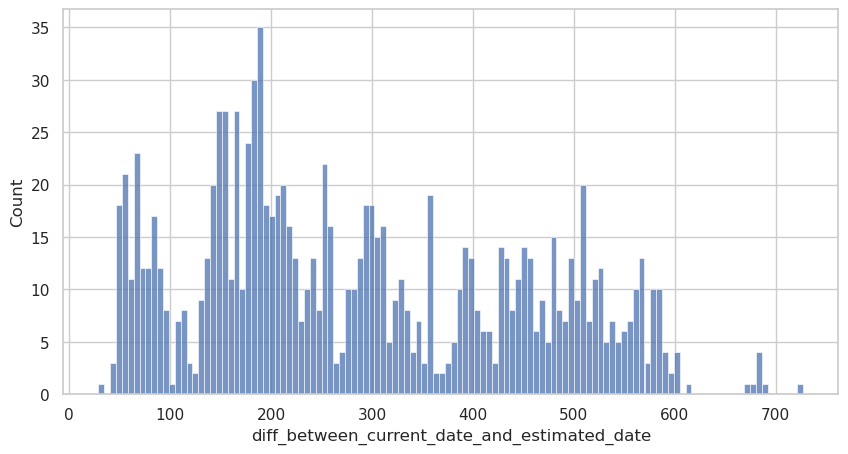

In [1080]:
sns.histplot(data=df_shipped_checking.diff_between_current_date_and_estimated_date.dt.days, bins=120)

<b>Для каждого статуса определим количество заказов в месяц в среднем.</b><br>
Для подсчёта количества недоставленных заказов в месяц в среднем берём значения дат из order_estimated_delivery_date (обещанная дата доставки).

In [1081]:
df_orders_with_purch_not_delivered_month = (df_orders_with_purch_not_delivered
                                            [['order_id', 'order_status', 'order_estimated_delivery_date']])

In [1082]:
df_orders_with_purch_not_delivered_month.loc[:, 'order_estimated_delivery_date'] = df_orders_with_purch_not_delivered_month['order_estimated_delivery_date'].dt.strftime('%Y-%m')

In [1083]:
df_orders_with_purch_not_delivered_month.head()

,order_id,order_status,order_estimated_delivery_date
44,ee64d42b8cf066f35eac1cf57de1aa85,shipped,2018-06-01
128,15bed8e2fec7fdbadb186b57c46c92f2,processing,2017-10-01
154,6942b8da583c2f9957e990d028607019,shipped,2018-02-01
162,36530871a5e80138db53bcfd8a104d90,shipped,2017-06-01
231,4d630f57194f5aba1a3d12ce23e71cd9,shipped,2017-12-01


In [1084]:
df_orders_not_delivered_in_each_month = (df_orders_with_purch_not_delivered_month
                                         .groupby(['order_status', 'order_estimated_delivery_date'], as_index=False)
                                         .agg({'order_id':'count'})
                                         .rename(columns={'order_id':'quantity', 'order_estimated_delivery_date':'estimated_year_and_month'}))

In [1085]:
df_orders_not_delivered_in_each_month.head()

,order_status,estimated_year_and_month,quantity
0,canceled,2016-10-01,2
1,canceled,2016-11-01,1
2,canceled,2016-12-01,5
3,canceled,2017-02-01,1
4,canceled,2017-03-01,23


In [1086]:
df_orders_not_delivered_in_each_month.shape

(64, 3)

In [1087]:
df_not_delivered_mean_per_month = (df_orders_not_delivered_in_each_month
                                   .groupby('order_status', as_index=False)
                                   .agg({'quantity':'mean'}).rename(columns={'quantity':'avg_per_month'}))

In [1088]:
df_not_delivered_mean_per_month

,order_status,avg_per_month
0,canceled,20.681818
1,processing,15.842105
2,shipped,48.086957


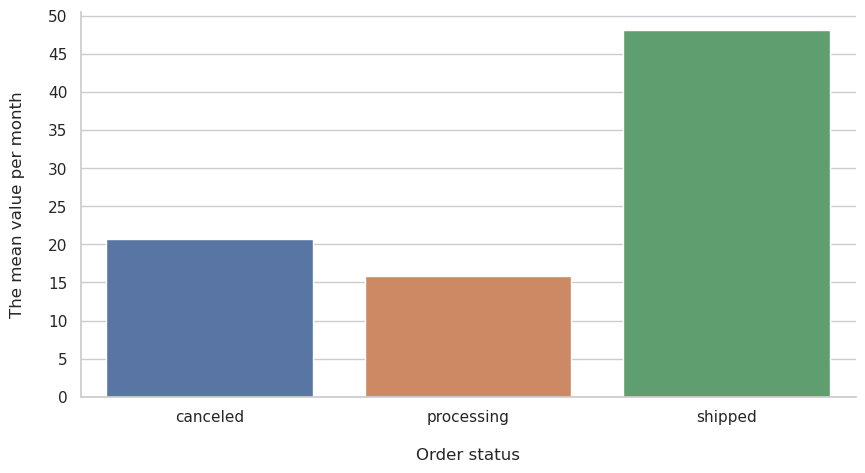

In [1089]:
figure = sns.barplot(data=df_not_delivered_mean_per_month, x='order_status', y='avg_per_month')

figure.set_xlabel('\nOrder status')              # Label of x axis
figure.set_ylabel('The mean value per month\n')  # Label of y axis
plt.yticks(range(0, 55, 5))
sns.despine()

<b>Полученные данные показывают количество недоставленных заказов в месяц в среднем. Среди них:</b>
<ol>
<li>Отменённые заказы (<b>canceled</b>): данные заказы были отменены покупателем во время доставки или в момент, когда заказ ещё не был передан в службу доставки.</li>
<li>Заказы, находящие в процессе сборки (<b>processing</b>): данные заказы не были переданы продавцом в службу доставки в максимально возможный срок.</li>
<li>Отгруженные со склада заказы (<b>shipped</b>): данные заказы всё ещё находятся в пути, но они уже не могут быть доставлены в обещенную дату.</li>
</ol>

<b>Ответ:</b><br>
canceled: 20 заказов в месяц в среднем<br>
processing: 15 заказов в месяц в среднем<br>
shipped: 48 заказов в месяц в среднем<br>
(В ответе значения были округлены до целого в меньшую сторону, так как количество заказов не может быть дробным числом)

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [1090]:
df_items_with_purch.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [1091]:
df_orders_with_purch.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


В таблице df_orders_with_purch нет отдельной колонки, содержащей время оплаты счёта (по моему предположению, order_approved_at заполняется после предоплаты части заказа, то есть при оплате счёта данная колонка уже заполнена. Данный момент подбробно расписан в блоке определения покупок). Считаем, что счёт оплачивается в день order_approved_at и на его оплату есть ограничение по времени (например 1 день). Это логично, так как в целях магазина как можно скорее оформить покупку после предоплаты. К тому же, предоплаченный товар (предоплата составляет некоторую часть полной суммы заказа) не может быть забронирован у продавца на долгое время (моё личное мнение).

In [1092]:
df_items_with_purch_with_date = (df_items_with_purch
                                 .merge(df_orders_with_purch[['order_id', 'order_approved_at']], 
                                        how='inner', on='order_id'))

In [1093]:
df_items_with_purch_with_date.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 09:45:35
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 11:05:13
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:48:30
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:10:18
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 14:10:13


In [1094]:
df_items_with_purch_with_date.loc[:, 'order_approved_at'] = (df_items_with_purch_with_date['order_approved_at']
                                                             .dt.day_name())

In [1095]:
df_items_with_purch_with_date.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,Wednesday
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,Sunday
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,Saturday


In [1096]:
product_id_quantity_weekday = (df_items_with_purch_with_date.
                               groupby(['product_id', 'order_approved_at'], as_index=False)
                               .agg({'order_id':'count'})
                               .rename(columns={'order_id':'quantity'})
                               .sort_values('quantity', ascending=False))

In [1097]:
product_id_quantity_weekday.head()

,product_id,order_approved_at,quantity
40927,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
20077,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
40922,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,96
15878,422879e10f46682990de24d770e7f83d,Tuesday,89
40928,aca2eb7d00ea1a7b8ebd4e68314663af,Wednesday,89


In [1098]:
product_id_quantity_weekday.shape

(60918, 3)

В таблице product_id_quantity_weekday для каждого product_id опрделим индексы с максимальными значениями в колонке quantity.

In [1099]:
max_quantity_index = product_id_quantity_weekday.groupby('product_id')['quantity'].idxmax()

In [1100]:
max_quantity_index

product_id
00066f42aeeb9f3007548bb9d3f33c38        0
00088930e925c41fd95ebfe695fd2655        1
0009406fd7479715e4bef61dd91f2462        2
000b8f95fcb9e0096488278317764d19        3
000d9be29b5207b54e86aa1b1ac54872        5
                                    ...  
fff6177642830a9a94a0f2cba5e476d1    60910
fff81cc3158d2725c0655ab9ba0f712c    60912
fff9553ac224cec9d15d49f5a263411f    60913
fffdb2d0ec8d6a61f0a0a0db3f25b441    60916
fffe9eeff12fcbd74a2f2b007dde0c58    60917
Name: quantity, Length: 32830, dtype: int64

In [1101]:
frequently_weekday_for_each_product = (product_id_quantity_weekday
                                       .loc[max_quantity_index, :].sort_values('quantity', ascending=False))

In [1102]:
frequently_weekday_for_each_product.head()

,product_id,order_approved_at,quantity
40927,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
20077,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
15878,422879e10f46682990de24d770e7f83d,Tuesday,89
36430,99a4788cb24856965c36a24e339b6058,Tuesday,82
13014,368c6c730842d78016ad823897a372db,Thursday,80


In [1103]:
frequently_weekday_for_each_product.shape

(32830, 3)

### Ответ: таблица frequently_weekday_for_each_product

## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [1104]:
df_customers_with_purch.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [1105]:
df_orders_with_purch.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


Как и в прошлом задании, считаем, что покупка совершается в день, указанный в колонке order_approved_at (т.е. в данный день оплачивается счёт заказа).

In [1106]:
df_customers_purch_with_date = (df_customers_with_purch[['customer_id', 'customer_unique_id']]
                                .merge(df_orders_with_purch[['customer_id', 'order_approved_at']], 
                                       on='customer_id', how='inner'))

In [1107]:
df_customers_purch_with_date.head()

,customer_id,customer_unique_id,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09


Получаем таблицу, в которой customer_id - позаказный идентификатор пользователя, customer_unique_id - уникальный идентификатор пользователя (аналог номера паспорта), order_approved_at - дата совершения покупки.

Приведём даты в колонке order_approved_at к типу год-месяц (также будет указан день 1, но в данном случае это неважно).

In [1108]:
df_customers_purch_with_date.loc[:, 'order_approved_at'] = (df_customers_purch_with_date
                                                            .order_approved_at.dt.strftime('%Y-%m'))

In [1109]:
df_customers_purch_with_date.head()

,customer_id,customer_unique_id,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-01
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-01
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-01
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-01


In [1110]:
df_customers_purch_with_date.dtypes

customer_id                   object
customer_unique_id            object
order_approved_at     datetime64[ns]
dtype: object

In [1111]:
df_quantity_per_month = (df_customers_purch_with_date
                         .groupby(['customer_unique_id', 'order_approved_at'], as_index=False)
                         .agg({'customer_id':'count'})
                         .rename(columns={'customer_id':'quantity_of_purch'})
                         .sort_values('quantity_of_purch', ascending=False))

In [1112]:
df_quantity_per_month.head()

,customer_unique_id,order_approved_at,quantity_of_purch
7251,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,6
23682,3e43e6105506432c953e165fb2acf44c,2018-02-01,4
14335,25a560b9a6006157838aab1bdbd68624,2017-04-01,4
50086,83e7958a94bd7f74a9414d8782f87628,2017-01-01,4
61531,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,4


In [1113]:
df_quantity_per_month.shape

(96992, 3)

Определим количество дней в каждом месяце и разделим данное число на 7, чтобы получить количество недель в каждом месяце. Полученное число чаще всего будет нецелым, так как во всех месяцах, кроме февраля (28 дней / 7 = 4 недели, но в високосный год в феврале 29 дней, то есть в високосный год февраль тоже содержит нецелое число недель), содержится нецелое число недель.

Для определения количества дней в месяце воспользуемся функцией monthrange(year, month) модуля calendar. Данная функция возвращает 2 значения: день недели первого числа рассматриваемого месяца и количество дней в месяце. Нам необходимо только второе значение.

In [1114]:
df_quantity_per_month['weeks'] = (df_quantity_per_month.order_approved_at
                                           .apply(lambda x: calendar.monthrange(x.year, x.month)[1] / 7))

In [1115]:
df_quantity_per_month.head()

,customer_unique_id,order_approved_at,quantity_of_purch,weeks
7251,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,6,4.428571
23682,3e43e6105506432c953e165fb2acf44c,2018-02-01,4,4.000000
14335,25a560b9a6006157838aab1bdbd68624,2017-04-01,4,4.285714
50086,83e7958a94bd7f74a9414d8782f87628,2017-01-01,4,4.428571
61531,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,4,4.000000


In [1116]:
df_quantity_per_month.quantity_of_purch.value_counts()

quantity_of_purch
1    95716
2     1222
3       46
4        7
6        1
Name: count, dtype: int64

In [1117]:
df_quantity_per_month.quantity_of_purch.quantile(0.98)

1.0

In [1118]:
df_quantity_per_month.quantity_of_purch.quantile(0.99)

2.0

Чаще всего (в 98% случаев) в месяц был куплен только один заказ.

В задании сказано "Сколько у каждого из пользователей в среднем покупок в неделю (<b>по месяцам</b>)?" Не очень понятно, что значит "по месяцам". Возможны 2 случая:
<ol>
<li>Подразумевается год и месяц (как в таблице df_quantity_per_month).</li>
<li>Подразумевается месяц независимо от года.</li>
</ol>
Определим, как много пользователей совершили покупки в один и тот же месяц разных лет.

In [1119]:
checking = df_quantity_per_month.copy()

In [1120]:
checking['order_approved_at'] = checking.order_approved_at.dt.month_name()

In [1121]:
checking.head()

,customer_unique_id,order_approved_at,quantity_of_purch,weeks
7251,12f5d6e1cbf93dafd9dcc19095df0b3d,January,6,4.428571
23682,3e43e6105506432c953e165fb2acf44c,February,4,4.000000
14335,25a560b9a6006157838aab1bdbd68624,April,4,4.285714
50086,83e7958a94bd7f74a9414d8782f87628,January,4,4.428571
61531,a239b8e2fbce33780f1f1912e2ee5275,February,4,4.000000


In [1122]:
print(checking.duplicated(subset=['customer_unique_id', 'order_approved_at']).sum())
# количество пользователей, совершивших покупки в один и тот же месяц разных лет.

41


In [1123]:
checking.loc[checking.duplicated(subset=['customer_unique_id', 'order_approved_at'], keep=False)].head()

,customer_unique_id,order_approved_at,quantity_of_purch,weeks
53454,8d50f5eadf50201ccdcedfb9e2ac8455,August,3,4.428571
53447,8d50f5eadf50201ccdcedfb9e2ac8455,July,2,4.428571
53452,8d50f5eadf50201ccdcedfb9e2ac8455,May,2,4.428571
53453,8d50f5eadf50201ccdcedfb9e2ac8455,July,2,4.428571
37927,63cfc61cee11cbe306bff5857d00bfe4,May,2,4.428571


In [1124]:
checking.loc[checking.duplicated(subset=['customer_unique_id', 'order_approved_at'], keep=False)].shape

(82, 4)

In [1125]:
(checking
 .loc[checking.duplicated(subset=['customer_unique_id', 'order_approved_at'], keep=False)]
 .quantity_of_purch.describe())

count    82.000000
mean      1.121951
std       0.364818
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       3.000000
Name: quantity_of_purch, dtype: float64

In [1126]:
print(checking.customer_unique_id.nunique())
# количество уникальных пользователей, совершивших покупки

95103


Видим, что из всех 95103 пользователей, совершивших покупки, лишь 41 пользователь совершили покупки в один и тот же месяц разных лет.<br>
Считаем, что в задании в словосочетании 'по месяцам' имеется ввиду месяц и соответствующий ему год, так как не вижу смысла в поиске среднего количества покупок, сделанных в один и тот же месяц разных лет, для каждого пользователя и месяца.

Определим сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)

In [1127]:
df_quantity_per_month['avg_per_week'] = df_quantity_per_month.quantity_of_purch / df_quantity_per_month.weeks

In [1128]:
df_quantity_per_month.head()

,customer_unique_id,order_approved_at,quantity_of_purch,weeks,avg_per_week
7251,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,6,4.428571,1.354839
23682,3e43e6105506432c953e165fb2acf44c,2018-02-01,4,4.000000,1.000000
14335,25a560b9a6006157838aab1bdbd68624,2017-04-01,4,4.285714,0.933333
50086,83e7958a94bd7f74a9414d8782f87628,2017-01-01,4,4.428571,0.903226
61531,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,4,4.000000,1.000000


In [1129]:
df_quantity_per_week = (df_quantity_per_month[['customer_unique_id', 'order_approved_at', 'avg_per_week']]
                        .sort_values('avg_per_week', ascending=False))

In [1130]:
df_quantity_per_week.head()

,customer_unique_id,order_approved_at,avg_per_week
7251,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,1.354839
61531,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,1.000000
68655,b4e4f24de1e8725b74e4a1f4975116ed,2018-02-01,1.000000
23682,3e43e6105506432c953e165fb2acf44c,2018-02-01,1.000000
14335,25a560b9a6006157838aab1bdbd68624,2017-04-01,0.933333


In [1131]:
df_quantity_per_week.shape

(96992, 3)

Для удобства округлим значения в колонке avg_per_week до 3 знака после запятой.

In [1132]:
df_quantity_per_week['avg_per_week'] = round(df_quantity_per_week.avg_per_week, 3)

In [1133]:
df_quantity_per_week.head()

,customer_unique_id,order_approved_at,avg_per_week
7251,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-01,1.355
61531,a239b8e2fbce33780f1f1912e2ee5275,2017-02-01,1.000
68655,b4e4f24de1e8725b74e4a1f4975116ed,2018-02-01,1.000
23682,3e43e6105506432c953e165fb2acf44c,2018-02-01,1.000
14335,25a560b9a6006157838aab1bdbd68624,2017-04-01,0.933


In [1134]:
df_quantity_per_week.avg_per_week.value_counts().sort_values()

avg_per_week
1.355        1
0.933        2
0.903        2
1.000        3
0.750        6
0.700       13
0.677       27
0.500      162
0.467      331
0.452      729
0.250     8020
0.233    29294
0.226    58402
Name: count, dtype: int64

In [1135]:
df_quantity_per_week.avg_per_week.describe()

count    96992.000000
mean         0.233363
std          0.029510
min          0.226000
25%          0.226000
50%          0.226000
75%          0.233000
max          1.355000
Name: avg_per_week, dtype: float64

<Axes: xlabel='avg_per_week', ylabel='count'>

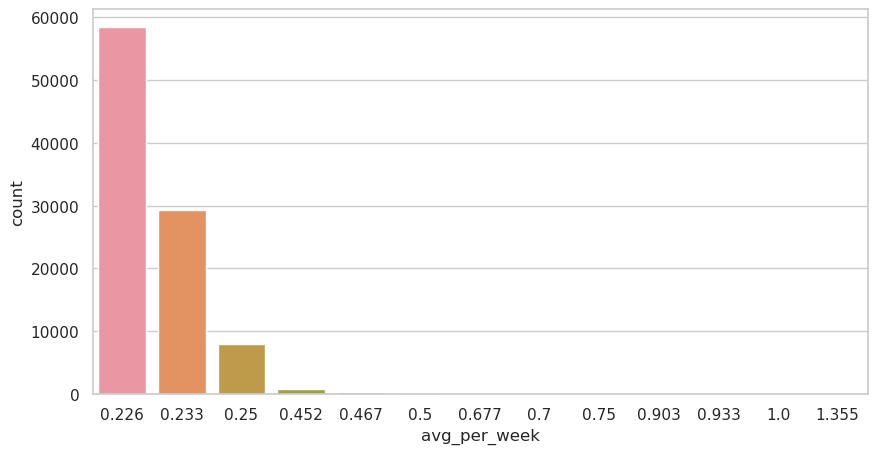

In [1136]:
sns.countplot(data=df_quantity_per_week, x='avg_per_week')

### Ответ: таблица df_quantity_per_week

## 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [1137]:
df_customers_with_purch.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [1138]:
df_customers_with_purch.shape

(98346, 5)

In [1139]:
df_orders_with_purch.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [1140]:
df_orders_with_purch.shape

(98346, 8)

Как и в прошлом задании, считаем, что покупка совершается в день, указанный в колонке order_approved_at (т.е. в данный день оплачивается счёт заказа).

In [1141]:
df_customers_with_purch_date = (df_customers_with_purch[['customer_id', 'customer_unique_id']]
                                .merge(df_orders_with_purch[['customer_id', 'order_approved_at']], 
                                       on='customer_id', how='inner'))

In [1142]:
df_customers_with_purch_date.head()

,customer_id,customer_unique_id,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09


In [1143]:
df_customers_with_purch_date.shape

(98346, 3)

In [1144]:
df_customers_with_purch_date.isna().sum()

customer_id            0
customer_unique_id     0
order_approved_at     14
dtype: int64

Заказы с пропущенными значениями в колонке order_approved_at относятся к заказам статуса delivered. Найдём данные заказы в таблице df_orders_with_purch и убедимся в этом.

In [1145]:
df_customers_with_missed_date = (df_customers_with_purch_date
                                 .loc[df_customers_with_purch_date.order_approved_at.isna()])

In [1146]:
df_customers_with_missed_date.head()

,customer_id,customer_unique_id,order_approved_at
8874,0bf35cac6cc7327065da879e2d90fae8,c4c0011e639bdbcf26059ddc38bd3c18,NaT
13747,1e101e0daffaddce8159d25a8e53f2b2,c8822fce1d0bfa7ddf0da24fff947172,NaT
20657,d5de688c321096d15508faae67a27051,d49f3dae6bad25d05160fc17aca5942d,NaT
22481,07a2a7e0f63fd8cb757ed77d4245623c,79af1bbf230a2630487975aa5d7d6220,NaT
27168,68d081753ad4fe22fc4d410a9eb1ca01,2e0a2166aa23da2472c6a60c4af6f7a6,NaT


In [1147]:
df_customers_with_missed_date.shape

(14, 3)

In [1148]:
df_orders_checking_missed = (df_orders_with_purch
                             .loc[df_orders_with_purch['customer_id']
                                  .isin(df_customers_with_missed_date['customer_id'])])

In [1149]:
df_orders_checking_missed

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


In [1150]:
df_orders_checking_missed.shape

(14, 8)

Все 14 заказов относятся к статусу delivered, то есть они были доставлено до пользователя. Однако, как я предположил на этапе определения покупок, из-за какой-то ошибки колонка order_approved_at не заполнилась. Можно понять, что должно соблюдаться неравенство:<br> <b>order_purchase_timestamp < order_approved_at < order_delivered_carrier_date</b> <br>
У каждого заказа год и месяц в колонках order_purchase_timestamp и order_delivered_carrier_date совпадают (было определено визуально, так как заказов всего 14), значит в колонке order_approved_at у данных заказов должны были быть такие же месяц и год, как и в колонках order_purchase_timestamp и order_delivered_carrier_date.<br>
Заказы в когортном анализе будут разбиты на когорты год-месяц, поэтому в качестве даты order_approved_at для данных заказов возьмём дату order_purchase_timestamp. 

In [1151]:
df_orders_checking_missed_for_fillna = (df_orders_checking_missed
                                        .drop(columns='order_approved_at')
                                        .rename(columns={'order_purchase_timestamp': 'order_approved_at'})
                                        .set_index('customer_id'))
# Далее будем заполнять пустые значения в таблице df_customers_with_purch_date с помощью метода fillna() 

In [1152]:
df_orders_checking_missed_for_fillna

,order_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
customer_id,,,,,,
2127dc6603ac33544953ef05ec155771,e04abd8149ef81b95221e88f6ed9ab6a,delivered,2017-02-18 14:40:00,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
4c1ccc74e00993733742a3c786dc3c1f,8a9adc69528e1001fc68dd0aaebbb54a,delivered,2017-02-18 12:45:31,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
2941af76d38100e0f8740a374f1a5dc3,7013bcfc1c97fe719a7b5e05e61c12db,delivered,2017-02-18 13:29:47,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
29c35fc91fc13fb5073c8f30505d860d,5cf925b116421afa85ee25e99b4c34fb,delivered,2017-02-18 16:48:35,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
1e101e0daffaddce8159d25a8e53f2b2,12a95a3c06dbaec84bcfb0e2da5d228a,delivered,2017-02-17 13:05:55,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
684cb238dc5b5d6366244e0e0776b450,c1d4211b3dae76144deccd6c74144a88,delivered,2017-01-19 12:48:08,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
68d081753ad4fe22fc4d410a9eb1ca01,d69e5d356402adc8cf17e08b5033acfb,delivered,2017-02-19 01:28:47,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
0bf35cac6cc7327065da879e2d90fae8,d77031d6a3c8a52f019764e68f211c69,delivered,2017-02-18 11:04:19,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
d5de688c321096d15508faae67a27051,7002a78c79c519ac54022d4f8a65e6e8,delivered,2017-01-19 22:26:59,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16


In [1153]:
df_customers_with_purch_date = (df_customers_with_purch_date.set_index('customer_id')
                                .fillna(df_orders_checking_missed_for_fillna).reset_index())

In [1154]:
df_customers_with_purch_date.head()

,customer_id,customer_unique_id,order_approved_at
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09


In [1155]:
df_customers_with_purch_date.isna().sum()

customer_id           0
customer_unique_id    0
order_approved_at     0
dtype: int64

Определим, к какой когорте относится каждый пользователь. Для этого отсортируем данные по order_approved_at по возрастанию и затем удалим все строки с повторами в колонке customer_unique_id, оставляя только самое первое появление.

In [1156]:
df_customers_cohort = (df_customers_with_purch_date[['customer_unique_id', 'order_approved_at']]
                       .sort_values('order_approved_at')
                       .drop_duplicates(subset=['customer_unique_id'], keep='first'))

In [1157]:
df_customers_cohort.head()

,customer_unique_id,order_approved_at
20915,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38
17357,14359ea0c7a105749c0a56478825b015,2016-10-04 09:43:32
59049,b8b8726af116a5cfb35b0315ecef9172,2016-10-04 10:18:57
19678,87776adb449c551e74c13fc34f036105,2016-10-04 10:19:23
21583,88bc832f104b6dd684a17dbb1b76e778,2016-10-04 10:25:46


In [1158]:
df_customers_cohort.loc[:, 'order_approved_at'] = (df_customers_cohort
                                                   .order_approved_at.dt.strftime('%Y-%m'))

In [1159]:
df_customers_cohort = df_customers_cohort.rename(columns={'order_approved_at': 'cohort'})

Получаем таблице с информацией о том, к какой горте относится каждый пользователь.

In [1160]:
df_customers_cohort.head()

,customer_unique_id,cohort
20915,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-01
17357,14359ea0c7a105749c0a56478825b015,2016-10-01
59049,b8b8726af116a5cfb35b0315ecef9172,2016-10-01
19678,87776adb449c551e74c13fc34f036105,2016-10-01
21583,88bc832f104b6dd684a17dbb1b76e778,2016-10-01


In [1161]:
df_customers_cohort.shape

(95116, 2)

In [1162]:
df_customers_cohort.dtypes

customer_unique_id            object
cohort                datetime64[ns]
dtype: object

In [1163]:
df_customers_with_purch_date_and_cohort = (df_customers_with_purch_date
                                           .merge(df_customers_cohort, on='customer_unique_id', how='left'))

In [1164]:
df_customers_with_purch_date_and_cohort.head()

,customer_id,customer_unique_id,order_approved_at,cohort
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,2017-05-01
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,2018-01-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10,2018-05-01
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,2018-03-01
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09,2018-07-01


In [1165]:
df_customers_with_purch_date_and_cohort.shape

(98346, 4)

Проверим, что когорты были присвоены верно.

In [1166]:
(df_customers_with_purch_date_and_cohort
 .loc[df_customers_with_purch_date_and_cohort.duplicated(subset='customer_unique_id', keep=False)]
 .sort_values(['customer_unique_id', 'order_approved_at']).head(50))

,customer_id,customer_unique_id,order_approved_at,cohort
19825,1b4a75b3478138e99902678254b260f4,004288347e5e88a27ded2bb23747066c,2017-07-27 14:25:14,2017-07-01
21848,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,2018-01-14 07:49:28,2017-07-01
71649,49cf243e0d353cd418ca77868e24a670,004b45ec5c64187465168251cd1c9c2f,2017-09-05 04:30:20,2017-09-01
86038,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,2018-05-29 03:31:20,2017-09-01
60730,f530197ea86ced9488a03d055e118ebf,0058f300f57d7b93c477a131a59b36c3,2018-02-19 17:20:52,2018-02-01
35888,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,2018-03-22 18:27:58,2018-02-01
54282,876356df457f952458a764348e1858bc,00a39521eb40f7012db50455bf083460,2018-05-23 20:35:15,2018-05-01
86436,cbb68c721ba9ddb30d8a490cc1897fa1,00a39521eb40f7012db50455bf083460,2018-06-03 10:50:00,2018-05-01
8864,c0a44bf37d5601228051fc07852f951f,00cc12a6d8b578b8ebd21ea4e2ae8b27,2017-03-21 19:25:22,2017-03-01
659,102fc0966044243157bb81e4ee0a251e,00cc12a6d8b578b8ebd21ea4e2ae8b27,2017-03-21 19:25:23,2017-03-01


Видим, что у первого дублирующегося значения год и месяц даты колонки order_approved_at совпадают с годом и месяцем в cohort. У последующих дублирующихся значений дата в cohort остаётся прежней, но дата в order_approved_at меняется.

In [1167]:
df_customers_with_purch_date_and_cohort.order_approved_at.describe()

count                            98346
mean     2018-01-01 13:49:56.171506944
min                2016-09-15 12:16:38
25%      2017-09-13 18:44:22.249999872
50%                2018-01-20 12:51:00
75%                2018-05-05 10:34:01
max                2018-09-03 17:40:06
Name: order_approved_at, dtype: object

В задании сказано "В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц". 
Так как были собраны данные за период (2016-09-15, 2018-09-03), то можно понять, что данные за полный год были собраны только в 2017 году. Следовательно, проведём когортный анализ только для данных 2017 года.

In [1168]:
df_customers_cohort_analysis_2017 = (df_customers_with_purch_date_and_cohort
                                     .query("'2016-12-31' < order_approved_at < '2018-01-01' & cohort > '2016-12-01'"))

In [1169]:
df_customers_cohort_analysis_2017.loc[:, 'order_approved_at'] = (df_customers_cohort_analysis_2017
                                                                 .order_approved_at.dt.strftime('%Y-%m'))

In [1170]:
df_customers_cohort_analysis_2017 = (df_customers_cohort_analysis_2017
                                     .rename(columns={'order_approved_at':'current_month'}))

In [1171]:
df_customers_cohort_analysis_2017.head()

,customer_id,customer_unique_id,current_month,cohort
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-01,2017-05-01
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,2017-09-01,2017-09-01
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,2017-11-01,2017-11-01
10,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,2017-11-01,2017-11-01
12,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,2017-09-01,2017-09-01


In [1172]:
df_customers_cohort_analysis_2017.shape

(44340, 4)

Для подсчёта retention нам необходимо знать, сколько пользователей совершали покупки спустя заданное время. То есть в данном случае нет необходимости знать, как много покупок совершил один пользователь когорты в рассматриваемый месяц. Для дальнейшего когортного анализа и определения retention для каждой когорты спустя заданное время из таблицы df_customers_cohort_analysis_2017 удалим дублирующиеся значения [customer_unique_id, current_month]. Без этого мы бы считали количество покупок, сделанных когортой в определённый месяц (current_month), а не количество пользователей, совершивших покупки в определённый месяц (current_month).

In [1173]:
df_customers_cohort_analysis_2017_for_retention = (df_customers_cohort_analysis_2017
                                                   .drop_duplicates(subset=['customer_unique_id', 'current_month'], 
                                                                    keep='first'))

In [1174]:
df_customers_cohort_analysis_2017_for_retention.head()

,customer_id,customer_unique_id,current_month,cohort
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-01,2017-05-01
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,2017-09-01,2017-09-01
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,2017-11-01,2017-11-01
10,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,2017-11-01,2017-11-01
12,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,2017-09-01,2017-09-01


In [1175]:
df_customers_cohort_analysis_2017_for_retention.shape

(43610, 4)

In [1176]:
df_customers_cohort_analysis_2017_for_retention.dtypes

customer_id                   object
customer_unique_id            object
current_month         datetime64[ns]
cohort                datetime64[ns]
dtype: object

In [1177]:
df_customers_cohort_analysis_2017_for_retention.cohort.sort_values().unique()

<DatetimeArray>
['2017-01-01 00:00:00', '2017-02-01 00:00:00', '2017-03-01 00:00:00',
 '2017-04-01 00:00:00', '2017-05-01 00:00:00', '2017-06-01 00:00:00',
 '2017-07-01 00:00:00', '2017-08-01 00:00:00', '2017-09-01 00:00:00',
 '2017-10-01 00:00:00', '2017-11-01 00:00:00', '2017-12-01 00:00:00']
Length: 12, dtype: datetime64[ns]

Посчитаем, как много пользователей каждой когорты совершали покупки в каждый месяц.

In [1178]:
df_cohort_analysis_2017 = (df_customers_cohort_analysis_2017_for_retention
                           .groupby(['current_month', 'cohort'], as_index=False)
                           .agg({'customer_id':'count'}).rename(columns={'customer_id':'quantity'}))

In [1179]:
df_cohort_analysis_2017.head()

,current_month,cohort,quantity
0,2017-01-01,2017-01-01,709
1,2017-02-01,2017-01-01,4
2,2017-02-01,2017-02-01,1688
3,2017-03-01,2017-01-01,2
4,2017-03-01,2017-02-01,4


In [1180]:
df_cohort_analysis_2017.shape

(77, 3)

In [1181]:
df_cohort_analysis_2017 = (df_cohort_analysis_2017
                           .rename(columns={'current_month':'CohortPeriod', 'cohort':'Cohort'}))

In [1182]:
df_cohort_analysis_2017['CohortPeriod'] = (df_cohort_analysis_2017.CohortPeriod.dt.month 
                                           - df_cohort_analysis_2017.Cohort.dt.month)

In [1183]:
df_cohort_analysis_2017['Cohort'] = (df_cohort_analysis_2017
                                     .Cohort.dt.strftime('%Y-%m'))

In [1184]:
df_cohort_analysis_2017.head()

,CohortPeriod,Cohort,quantity
0,0,2017-01,709
1,1,2017-01,4
2,0,2017-02,1688
3,2,2017-01,2
4,1,2017-02,4


In [1185]:
df_cohort_analysis_2017_pivot = (df_cohort_analysis_2017
                                 .pivot(columns='CohortPeriod', index='Cohort', values='quantity'))

In [1186]:
df_cohort_analysis_2017_pivot

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
Cohort,,,,,,,,,,,,
2017-01,709.0,4.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,2.0,2.0
2017-02,1688.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,NaN
2017-03,2601.0,13.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,3.0,NaN,NaN
2017-04,2299.0,14.0,5.0,4.0,7.0,6.0,8.0,6.0,8.0,NaN,NaN,NaN
2017-05,3545.0,19.0,17.0,14.0,11.0,12.0,15.0,5.0,NaN,NaN,NaN,NaN
2017-06,3116.0,15.0,11.0,12.0,8.0,10.0,12.0,NaN,NaN,NaN,NaN,NaN
2017-07,3791.0,20.0,13.0,7.0,13.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4155.0,28.0,15.0,11.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4097.0,27.0,20.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CohortPeriod - количество пройденных месяцев с момента формирования когорты, то есть в колонке 0 показано, как много пользователей определённой когорты совершили покупки в месяц, соответствующий когорте, 1 - как много ползователей совершили покупки спустя месяц и тд.

Присвоим элементу с координатой (2017-01, 9) значение 0.

In [1187]:
df_cohort_analysis_2017_pivot.loc['2017-01', 9] = 0.0

In [1188]:
df_cohort_analysis_2017_pivot

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
Cohort,,,,,,,,,,,,
2017-01,709.0,4.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,0.0,2.0,2.0
2017-02,1688.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,NaN
2017-03,2601.0,13.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,3.0,NaN,NaN
2017-04,2299.0,14.0,5.0,4.0,7.0,6.0,8.0,6.0,8.0,NaN,NaN,NaN
2017-05,3545.0,19.0,17.0,14.0,11.0,12.0,15.0,5.0,NaN,NaN,NaN,NaN
2017-06,3116.0,15.0,11.0,12.0,8.0,10.0,12.0,NaN,NaN,NaN,NaN,NaN
2017-07,3791.0,20.0,13.0,7.0,13.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4155.0,28.0,15.0,11.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4097.0,27.0,20.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Считаем retention для каждой когорты (пока не в %).

In [1189]:
df_cohort_analysis_2017_pivot = (df_cohort_analysis_2017_pivot
                                 .apply(lambda x: x / df_cohort_analysis_2017_pivot[0]))

In [1190]:
df_cohort_analysis_2017_pivot

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
Cohort,,,,,,,,,,,,
2017-01,1.0,0.005642,0.002821,0.001410,0.004231,0.001410,0.004231,0.001410,0.001410,0.000000,0.002821,0.002821
2017-02,1.0,0.002370,0.002370,0.001777,0.004147,0.001185,0.002370,0.001777,0.001185,0.001777,0.001185,NaN
2017-03,1.0,0.004998,0.003460,0.003460,0.003460,0.001538,0.001538,0.003076,0.003076,0.001153,NaN,NaN
2017-04,1.0,0.006090,0.002175,0.001740,0.003045,0.002610,0.003480,0.002610,0.003480,NaN,NaN,NaN
2017-05,1.0,0.005360,0.004795,0.003949,0.003103,0.003385,0.004231,0.001410,NaN,NaN,NaN,NaN
2017-06,1.0,0.004814,0.003530,0.003851,0.002567,0.003209,0.003851,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005276,0.003429,0.001846,0.003429,0.001846,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006739,0.003610,0.002647,0.003851,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006590,0.004882,0.003417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1191]:
ur_style = (df_cohort_analysis_2017_pivot
            .style
            .set_caption('Retention by cohort')   # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')              # делаем белый фон для значений NaN
            .format("{:.4%}", na_rep=""))         # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
Cohort,,,,,,,,,,,,
2017-01,100.0000%,0.5642%,0.2821%,0.1410%,0.4231%,0.1410%,0.4231%,0.1410%,0.1410%,0.0000%,0.2821%,0.2821%
2017-02,100.0000%,0.2370%,0.2370%,0.1777%,0.4147%,0.1185%,0.2370%,0.1777%,0.1185%,0.1777%,0.1185%,
2017-03,100.0000%,0.4998%,0.3460%,0.3460%,0.3460%,0.1538%,0.1538%,0.3076%,0.3076%,0.1153%,,
2017-04,100.0000%,0.6090%,0.2175%,0.1740%,0.3045%,0.2610%,0.3480%,0.2610%,0.3480%,,,
2017-05,100.0000%,0.5360%,0.4795%,0.3949%,0.3103%,0.3385%,0.4231%,0.1410%,,,,
2017-06,100.0000%,0.4814%,0.3530%,0.3851%,0.2567%,0.3209%,0.3851%,,,,,
2017-07,100.0000%,0.5276%,0.3429%,0.1846%,0.3429%,0.1846%,,,,,,
2017-08,100.0000%,0.6739%,0.3610%,0.2647%,0.3851%,,,,,,,
2017-09,100.0000%,0.6590%,0.4882%,0.3417%,,,,,,,,


Видим, что самый высокий retention на 3й месяц оказался у когорты 2017-05 (0.3949%)

### Ответ: в период с января по декабрь 2017 года самым высоким retention на 3й месяц оказался у когорты 2017-05 (0.3949%).

## 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

In [1192]:
df_orders_with_purch.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [1193]:
df_orders_with_purch.shape

(98346, 8)

Как и в прошлом задании, считаем, что покупка совершается в день, указанный в колонке order_approved_at (т.е. в данный день оплачивается счёт заказа).

In [1194]:
print('Orders from {} to {}'.format(df_orders_with_purch['order_approved_at'].min(),
                                    df_orders_with_purch['order_approved_at'].max()))

Orders from 2016-09-15 12:16:38 to 2018-09-03 17:40:06


Следовательно, у нас есть данные почти за 2 года.

In [1195]:
df_items_with_purch.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Определим цену каждого заказа.

In [1196]:
order_prices = df_items_with_purch.groupby('order_id', as_index=False).agg({'price':'sum'})

In [1197]:
order_prices.head()

,order_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90


In [1198]:
order_prices.shape

(98346, 2)

Определим дату, относительно которой будет проводиться RFM-сегментация пользователей. Прибавим к максимальной дате из колонки order_approved_at таблицы df_orders_with_purch ещё 1 день. Относительно полученной даты будет проводиться дальнейший анализ.

In [1199]:
now_date = (max(df_orders_with_purch['order_approved_at']) + timedelta(days=1)).date()

In [1200]:
print(now_date)

2018-09-04


Проведём RFM-сегментацию за период, равный 2 года (то есть будут рассмотрены все имеющиеся покупки). 

In [1201]:
period = 365 * 2

In [1202]:
print(period)

730


Из прошлого задания помним, что в таблице с покупками df_orders_with_purch есть 14 заказов со статусом delivered, у которых пропущены значения в колонке order_approved_at.

In [1203]:
df_orders_with_purch.order_approved_at.isna().sum()

14

In [1204]:
df_orders_delivered_missed = df_orders_with_purch.loc[df_orders_with_purch.order_approved_at.isna()]

In [1205]:
df_orders_delivered_missed

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


В данном случае нам нужно заполнить пропуски точной датой. Рассмотрим подробнее разницу между order_approved_at и order_purchase_timestamp и разницу между order_delivered_carrier_date и order_approved_at во всей таблице df_orders_with_purch.

In [1206]:
(df_orders_with_purch['order_approved_at'] - df_orders_with_purch['order_purchase_timestamp']).describe()

count                        98332
mean     0 days 10:19:28.130801773
std      0 days 21:29:13.706188527
min                0 days 00:00:00
25%                0 days 00:12:54
50%         0 days 00:20:35.500000
75%                0 days 14:32:32
max               60 days 10:51:59
dtype: object

In [1207]:
(df_orders_with_purch.order_approved_at - df_orders_with_purch.order_purchase_timestamp).quantile(0.82)

Timedelta('0 days 23:57:07')

Видим, что примерно 82% всех купленных заказов создаются и покупаются в течение одних суток.

In [1208]:
(df_orders_with_purch.order_delivered_carrier_date - df_orders_with_purch.order_approved_at).describe()

count                        97643
mean     2 days 19:18:49.854940958
std      3 days 13:09:28.984594443
min            -172 days +18:44:38
25%                0 days 21:00:43
50%                1 days 19:38:24
75%                3 days 13:55:50
max              125 days 18:18:06
dtype: object

In [1209]:
(df_orders_with_purch.order_delivered_carrier_date - df_orders_with_purch.order_approved_at).quantile(0.30)

Timedelta('0 days 23:54:09.600000')

Примерно 30% всех купленных заказов покупаются и передаются в логистическую службу в течение одних суток. В среднем на это уходит 2 дня.

Следовательно, присвоим пропущенным значениям в колонке order_approved_at даты из order_purchase_timestamp соответствующих заказов, предполагая, что данные заказы были созданы и оплачены в один и тот же день (тем более, в дальнейшем анализе будут учитываться календарные дни без учёта точного времени).

Также можно заметить, что есть заказ, у которого разница между order_delivered_carrier_date и order_approved_at равна -172 дня, что кажется невозможным. Перед проведением RFM-сегментации рассмотрим данный заказ и остальные заказы, у которых данная разница получилась отрицательной.

In [1210]:
checking_diff = df_orders_with_purch.copy()

In [1211]:
checking_diff['diff_carrier_and_approved'] = (checking_diff.order_delivered_carrier_date 
                                                       - checking_diff.order_approved_at)

In [1212]:
checking_diff.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_carrier_and_approved
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2 days 08:47:45
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,0 days 11:06:33
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,0 days 04:54:37
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,3 days 17:54:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,0 days 21:26:05


In [1213]:
checking_negative_diff = (checking_diff.loc[checking_diff.diff_carrier_and_approved.dt.days < 0]
                          .sort_values('diff_carrier_and_approved'))

In [1214]:
checking_negative_diff.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_carrier_and_approved
25883,7c48bb55e8e4f7e56d412e9653db37bc,34ef6181341eb36c47fd601c46878f00,delivered,2018-07-16 18:40:53,2018-07-16 18:50:22,2018-01-26 13:35:00,2018-07-23 20:04:45,2018-08-07,-172 days +18:44:38
14562,1fab4ac9d85079b3da72a11475ae1685,f831c1fa80308975ec2b58e4877328e0,delivered,2017-09-01 19:04:22,2017-09-13 22:06:11,2017-09-04 13:10:23,2017-09-08 20:13:03,2017-09-20,-10 days +15:04:12
46163,0184d4ddb259e1a4cfc2871888cf97b8,09425ea1839abf2f0d289a0ff453fa21,delivered,2017-09-01 20:04:28,2017-09-13 22:17:15,2017-09-04 14:05:50,2017-09-09 15:12:44,2017-09-20,-10 days +15:48:35
98710,1378f9601350615613cc8832d6789c5d,988126b4ddf725d9724e4318872ea2ae,delivered,2017-09-01 20:28:02,2017-09-13 22:03:51,2017-09-04 18:07:55,2017-09-13 22:24:46,2017-09-29,-10 days +20:04:04
41592,8554cb37f7158cb0b082a841d24a4589,788e845925ff64c9df5d8ba40e28cf50,delivered,2017-09-01 18:40:44,2017-09-13 21:58:04,2017-09-04 19:12:19,2017-09-08 20:07:45,2017-10-02,-10 days +21:14:15


In [1215]:
checking_negative_diff.shape

(1359, 9)

In [1216]:
checking_negative_diff.diff_carrier_and_approved.describe()

count                           1359
mean     -2 days +23:14:52.846946285
std        4 days 19:18:28.055754668
min              -172 days +18:44:38
25%                -2 days +22:02:36
50%                -1 days +06:49:56
75%         -1 days +22:35:04.500000
max                -1 days +23:59:39
Name: diff_carrier_and_approved, dtype: object

Всего 1359 заказов с отрицательной разницей между order_delivered_carrier_date и order_approved_at. В среднем (имеется ввиду медиана) данная разница у этих заказов составляет -1 день, однако есть одно экстремальное значение, равное -172 дня. Найдём данные заказы в таблице df_items_with_purch и проверим, успел ли продавец передать данные заказы в логистическую службу.

In [1217]:
checking_negative_diff_with_limit_date = (checking_negative_diff
                                          .merge(df_items_with_purch[['order_id', 'shipping_limit_date']].drop_duplicates(subset='order_id'), 
                                                on='order_id', how='inner'))

In [1218]:
checking_negative_diff_with_limit_date.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_carrier_and_approved,shipping_limit_date
0,7c48bb55e8e4f7e56d412e9653db37bc,34ef6181341eb36c47fd601c46878f00,delivered,2018-07-16 18:40:53,2018-07-16 18:50:22,2018-01-26 13:35:00,2018-07-23 20:04:45,2018-08-07,-172 days +18:44:38,2018-07-20 18:50:22
1,1fab4ac9d85079b3da72a11475ae1685,f831c1fa80308975ec2b58e4877328e0,delivered,2017-09-01 19:04:22,2017-09-13 22:06:11,2017-09-04 13:10:23,2017-09-08 20:13:03,2017-09-20,-10 days +15:04:12,2017-09-07 22:31:41
2,0184d4ddb259e1a4cfc2871888cf97b8,09425ea1839abf2f0d289a0ff453fa21,delivered,2017-09-01 20:04:28,2017-09-13 22:17:15,2017-09-04 14:05:50,2017-09-09 15:12:44,2017-09-20,-10 days +15:48:35,2017-09-07 22:31:42
3,1378f9601350615613cc8832d6789c5d,988126b4ddf725d9724e4318872ea2ae,delivered,2017-09-01 20:28:02,2017-09-13 22:03:51,2017-09-04 18:07:55,2017-09-13 22:24:46,2017-09-29,-10 days +20:04:04,2017-09-07 22:32:05
4,8554cb37f7158cb0b082a841d24a4589,788e845925ff64c9df5d8ba40e28cf50,delivered,2017-09-01 18:40:44,2017-09-13 21:58:04,2017-09-04 19:12:19,2017-09-08 20:07:45,2017-10-02,-10 days +21:14:15,2017-09-07 22:32:18


In [1219]:
checking_negative_diff_with_limit_date.shape

(1359, 10)

Найдём разницу между shipping_limit_date и order_delivered_carrier_date.

In [1220]:
checking_negative_diff_with_limit_date['diff_limit_and_carrier'] = (checking_negative_diff_with_limit_date.shipping_limit_date
                                                                   - checking_negative_diff_with_limit_date.order_delivered_carrier_date)

In [1221]:
checking_negative_diff_with_limit_date = checking_negative_diff_with_limit_date.sort_values('diff_limit_and_carrier')

In [1222]:
checking_negative_diff_with_limit_date.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_carrier_and_approved,shipping_limit_date,diff_limit_and_carrier
806,b59907afa60164e884ce406116efc58d,9c8fef93c079fbe536b901578adf6d2a,delivered,2018-07-02 08:44:56,2018-07-05 16:13:12,2018-07-05 12:45:00,2018-07-10 22:31:55,2018-07-20,-1 days +20:31:48,2018-07-05 04:31:01,-1 days +15:46:01
756,ad65db823bb3d24954abfc66ee67b165,b988047badca8720f31e6643508d0500,delivered,2018-07-01 17:41:47,2018-07-05 16:10:37,2018-07-05 11:11:00,2018-07-11 13:12:08,2018-07-23,-1 days +19:00:23,2018-07-05 04:31:16,-1 days +17:20:16
96,8883dd20e652369652c1abd7a411788f,65691ce6d0d99e673bd133ade0ec2362,delivered,2018-08-14 14:24:51,2018-08-20 14:36:32,2018-08-17 14:44:00,2018-08-20 17:37:56,2018-08-23,-3 days +00:07:28,2018-08-17 14:45:31,0 days 00:01:31
94,ed4116f3f55e67e9a26b9f1891ba2497,125cc79e58f69c02004d42cb9d549f4f,delivered,2018-08-09 13:21:48,2018-08-20 15:55:42,2018-08-17 13:29:00,2018-08-31 00:14:30,2018-08-29,-4 days +21:33:18,2018-08-17 16:30:58,0 days 03:01:58
765,9baa5b4e68d86c9f1694e1598b543a93,0332d8ec6d259a1caeda045188ffe70f,delivered,2018-07-02 23:13:07,2018-07-05 16:20:18,2018-07-05 11:55:00,2018-07-10 19:05:23,2018-07-25,-1 days +19:34:42,2018-07-05 16:31:40,0 days 04:36:40


In [1223]:
checking_negative_diff_with_limit_date.tail()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_carrier_and_approved,shipping_limit_date,diff_limit_and_carrier
1197,48b4f1f96d5ae13b404fe7d041a8d393,77151da438a727054ce6430fd175793a,delivered,2018-08-09 13:41:59,2018-08-09 14:35:22,2018-08-09 13:57:00,2018-08-24 16:44:28,2018-09-26,-1 days +23:21:38,2018-08-23 14:35:22,14 days 00:38:22
1098,ba992a67b91b76a97c227e1ad48658f5,f10d33418980c7f04fe434a6d6c85c5e,delivered,2018-08-03 14:48:15,2018-08-03 15:04:13,2018-08-03 13:58:00,2018-08-14 20:32:31,2018-08-30,-1 days +22:53:47,2018-08-17 15:04:13,14 days 01:06:13
278,a3270f2613a807c71433dada7bf3876a,2f3df719b7d2f0ce0eab4926ee355614,delivered,2018-07-03 17:05:33,2018-07-05 16:16:37,2018-07-04 12:06:00,2018-07-06 17:36:45,2018-07-30,-2 days +19:49:23,2018-07-19 17:31:32,15 days 05:25:32
261,f75d04d7bf218d0026ebdbd703d70fa0,1aeb1588530c8d12fbea98e9c6b102d3,delivered,2018-07-03 20:43:12,2018-07-05 16:34:57,2018-07-04 11:44:00,2018-07-13 16:41:32,2018-08-21,-2 days +19:09:03,2018-07-29 21:31:38,25 days 09:47:38
0,7c48bb55e8e4f7e56d412e9653db37bc,34ef6181341eb36c47fd601c46878f00,delivered,2018-07-16 18:40:53,2018-07-16 18:50:22,2018-01-26 13:35:00,2018-07-23 20:04:45,2018-08-07,-172 days +18:44:38,2018-07-20 18:50:22,175 days 05:15:22


В итоге, всего 1359 заказов с отрицательной разницей между order_delivered_carrier_date и order_approved_at. В заказе с экстремальным значением (-172 дня) явно была допущена ошибка при записи в колонку order_delivered_carrier_date, так как заказ не мог передан в службу доставки в тот момент, когда он ещё не существовал. Выяснилось, что 2 заказа были переданы продавцом в службу доставки после максимально допустимой даты (опоздание на 1 день). Остальные заказы были переданы вовремя.<br>
Примем, что для данных заказов (кроме заказа с экстремаьным значением) действовало особое условие, при котором оплата проходила после передачи в службу доставки. Заказ с экстрамальным значением оставим без изменений, так как ошибка в order_delivered_carrier_date никак не повлияет на RFM анализ. Насчёт 2 заказов, которые были переданы в службу доставки с опозданием: предположим, что продавцы нашли способ передать данные заказы после срока.

<b>Возвращаемся к RFM-сегментации</b>

In [1224]:
df_orders_with_purch_RFM = df_orders_with_purch[['order_id', 'customer_id', 'order_approved_at']]

In [1225]:
df_orders_with_purch_RFM.loc[df_orders_with_purch_RFM.order_approved_at.isna(), 'order_approved_at'] = (df_orders_delivered_missed
                                                                                                        .order_purchase_timestamp)

In [1226]:
df_orders_with_purch_RFM.head()

,order_id,customer_id,order_approved_at
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29


In [1227]:
df_orders_with_purch_RFM.shape

(98346, 3)

In [1228]:
df_orders_with_purch_RFM.order_approved_at.isna().any()

False

Для каждого заказа опрделим, как много прошло дней со дня покупки.

In [1229]:
df_orders_with_purch_RFM.loc[:, 'order_approved_at'] = (now_date - df_orders_with_purch_RFM.order_approved_at.dt.date)
# now_date - дата, относительно которой проводится анализ (была определена ранее)

In [1230]:
df_orders_with_purch_RFM.head()

,order_id,customer_id,order_approved_at
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,337 days
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,40 days
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,27 days
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,290 days
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,203 days


In [1231]:
df_orders_and_price_RFM = df_orders_with_purch_RFM.merge(order_prices, on='order_id', how='inner')

In [1232]:
df_orders_and_price_RFM.head()

,order_id,customer_id,order_approved_at,price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,337 days,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,40 days,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,27 days,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,290 days,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,203 days,19.90


In [1233]:
df_orders_and_price_RFM.shape

(98346, 4)

In [1234]:
df_orders_and_price_with_customers_RFM = (df_orders_and_price_RFM
                                          .merge(df_customers_with_purch[['customer_id', 'customer_unique_id']], 
                                                 how='left', on='customer_id'))

In [1235]:
df_orders_and_price_with_customers_RFM.head()

,order_id,customer_id,order_approved_at,price,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,337 days,29.99,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,40 days,118.70,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,27 days,159.90,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,290 days,45.00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,203 days,19.90,72632f0f9dd73dfee390c9b22eb56dd6


In [1236]:
df_orders_and_price_with_customers_RFM.shape

(98346, 5)

In [1237]:
df_main_RFM = df_orders_and_price_with_customers_RFM[['customer_unique_id', 'order_id', 'order_approved_at', 'price']]

In [1238]:
df_main_RFM.head()

,customer_unique_id,order_id,order_approved_at,price
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,337 days,29.99
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,40 days,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,27 days,159.90
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,290 days,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,203 days,19.90


In [1239]:
df_main_RFM = (df_main_RFM.rename(columns={'order_approved_at':'DaysSinceOrder', 'price':'price_for_order'}))

In [1240]:
df_main_RFM['DaysSinceOrder'] = df_main_RFM.DaysSinceOrder.dt.days

In [1241]:
df_main_RFM.head()

,customer_unique_id,order_id,DaysSinceOrder,price_for_order
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,337,29.99
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,40,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,27,159.90
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,290,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,203,19.90


In [1242]:
df_main_RFM.shape

(98346, 4)

In [1243]:
df_main_RFM.dtypes

customer_unique_id     object
order_id               object
DaysSinceOrder          int64
price_for_order       float64
dtype: object

### Recency, Frequency и Monetary
<b>Recency</b> - количество дней между последней покупкой пользователя и текущей датой (т.е. now_date).
Для определения Recency необходимо для каждого пользователя из колонки customer_unique_id определить
минимальное значение из DaysSinceOrder.<br>
<b>Frequency</b> - количество купленных одним пользователем заказов в течении рассматриваемого периода (2 года).
Так как приод в 2 года охватывает все данные, то для определения Frequency необходимо для каждого пользователя
из колонки customer_unique_id посчитать количество заказов из колонки order_id.<br>
<b>Monetary</b> - сумма всех сделанных пользователем покупок за рассматриваемый период. Как и в случае с Frequency, приод в 2 года охватывает все данные, поэтому для для определения Monetary необходимо для каждого пользователя из колонки customer_unique_id посчитать сумму из колонки price_for_order.

In [1244]:
df_main_RFM.DaysSinceOrder.max() < period
# Доказательство того, что рассматриваемый период охватывает все данные.

True

In [1245]:
df_RFM = (df_main_RFM
          .groupby('customer_unique_id', as_index=False)
          .agg({'DaysSinceOrder': 'min', 'order_id': 'count', 'price_for_order': 'sum'}))

In [1246]:
df_RFM = (df_RFM
          .rename(columns={'DaysSinceOrder': 'Recency', 'order_id': 'Frequency', 'price_for_order': 'Monetary'}))

In [1247]:
df_RFM.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90
2,0000f46a3911fa3c0805444483337064,543,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00


In [1248]:
df_RFM.shape

(95116, 4)

Теперь для каждый метрики нужно провести кластеризацию и определить границы каждого кластера.

In [1249]:
df_RFM[['Recency', 'Frequency', 'Monetary']].quantile([.0, .2, .4, .6, .8, 1.0])

,Recency,Frequency,Monetary
0.0,1.0,1.0,0.85
0.2,98.0,1.0,39.90
0.4,183.0,1.0,69.90
0.6,273.0,1.0,109.90
0.8,389.0,1.0,179.90
1.0,719.0,16.0,13440.00


Для определения границ метрики Recency будем использовать квантили, то есть разобьём данные колонки Recency на 5 групп:<br>
[q0; q0.2], (q0.2; q0.4], (q0.4; q0.6], (q0.6; q0.8], (q0.8; q1]<br> 
Как видим, в каждой группе содержится по 20% данных метрики Recency.<br>
Для метрики Frequency данный способ не подходит, так как 80% всех данных принадлежат значению 1. Для метрики Monetary данный способ также не подходит, так есть большой разрый между q0.8 и q1.

Введём ранги для метрики Recency:<br>
[q0; q0.2] : 5, (q0.2; q0.4] : 4, (q0.4; q0.6] : 3, (q0.6; q0.8] : 2, (q0.8; q1] : 1 <br>
Чем меньше Recency, тем выше ранг, так как Recency показывает количество прошедших дней со дня последней покупки.<br>

Определим ранговую систему для метрик Frequency и Monetary.

In [1250]:
df_Frequency = (df_RFM
                .groupby('Frequency', as_index=False)
                .agg({'customer_unique_id': 'count'})
                .rename(columns={'customer_unique_id': 'quantity_of_customers'}))

In [1251]:
df_Frequency

,Frequency,quantity_of_customers
0,1,92218
1,2,2659
2,3,191
3,4,29
4,5,9
5,6,5
6,7,3
7,9,1
8,16,1


In [1252]:
df_Frequency['percent'] = round((df_Frequency.quantity_of_customers / 
                                 df_Frequency.quantity_of_customers.sum() * 100), 5)

In [1253]:
df_Frequency

,Frequency,quantity_of_customers,percent
0,1,92218,96.95319
1,2,2659,2.79553
2,3,191,0.20081
3,4,29,0.03049
4,5,9,0.00946
5,6,5,0.00526
6,7,3,0.00315
7,9,1,0.00105
8,16,1,0.00105


In [1254]:
df_Frequency.query("Frequency > 4").percent.sum()

0.019969999999999998

Видим, что почти 97% покупателей за весь период совершили одну покупку. Присвоим данным пользователям ранг 1.<br>
2.8% покупателей за весь период совершили две покупки. Присвоим данным пользователям ранг 2.<br>
0.2% покупателей за весь период совершили три покупки. Присвоим данным пользователям ранг 3.<br>
0.03% покупателей за весь период совершили четыре покупки. Присвоим данным пользователям ранг 4.<br>
Остальные 0.02% покупателей за весь период совершили больше четырёх покуок. Присвоим данным пользователям ранг 5.

Ранги для метрики Frequency:<br> 
1 : 1, 2 : 2, 3 : 3, 4 : 4, [5; 16] : 5

In [1255]:
df_RFM.Monetary.nunique()

8596

/home/anton23/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


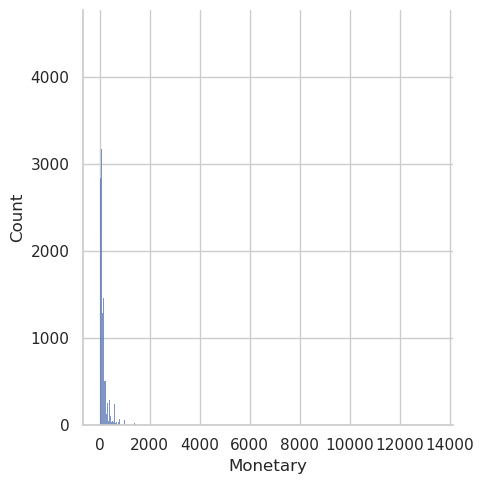

In [1256]:
sns.displot(df_RFM.Monetary)

/home/anton23/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


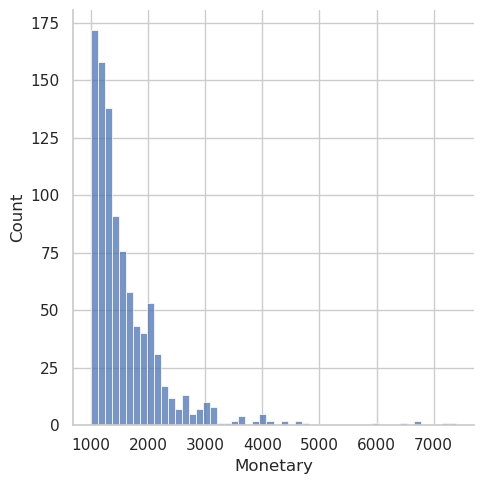

In [1257]:
sns.displot(df_RFM.query("1000 <  Monetary < 13400").Monetary)

In [1258]:
df_RFM.loc[df_RFM.Monetary < df_RFM.Monetary.max()].Monetary.max()

7388.0

Видим, что между максимальным значеним Monetary (13440) и значением 7388 нет данных вообще.

/home/anton23/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


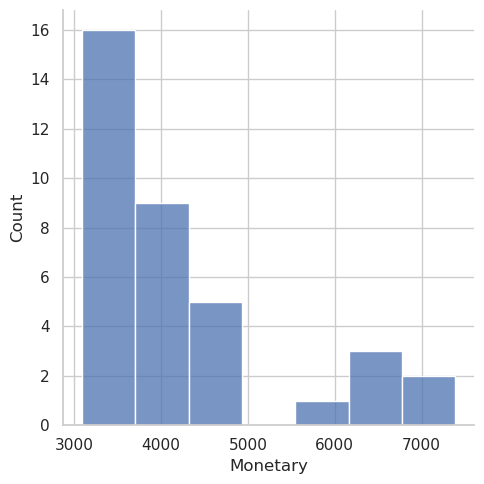

In [1259]:
sns.displot(df_RFM.query("3000 <  Monetary < 13400").Monetary)

In [1260]:
df_RFM.query("Monetary < 5000").Monetary.max()

4690.0

In [1261]:
df_RFM.query("Monetary > 5000").Monetary.min()

5934.6

In [1262]:
df_RFM.query("Monetary > 5000").Monetary.min() - df_RFM.query("Monetary < 5000").Monetary.max()

1244.6000000000004

Основная часть данных лежит на участке: [0.85; 4690]

In [1263]:
Monetary_range = df_RFM.query("Monetary < 5000").Monetary.max() - df_RFM.Monetary.min()

In [1264]:
Monetary_range

4689.15

In [1265]:
monetary_min = df_RFM.Monetary.min()

In [1266]:
monetary_min

0.85

In [1267]:
monetary_max = df_RFM.Monetary.max()

In [1268]:
monetary_max

13440.0

Введём ранги для метрики Monetary:<br>
[monetary_min; monetary_min + Monetary_range / 4] : 1 <br> 
(monetary_min + Monetary_range / 4; monetary_min + 2 * Monetary_range / 4] : 2<br>
(monetary_min + 2 * Monetary_range / 4; monetary_min + 3 * Monetary_range / 4] : 3<br> 
(monetary_min + 3 * Monetary_range / 4; monetary_min + Monetary_range] : 4<br>
(monetary_min + Monetary_range; monetary_max] : 5<br>

Для присвоения рангов метрикам Recency, Frequency и Monetary требуются 3 разные функции.

In [1269]:
quintiles = df_RFM[['Recency']].quantile([.2, .4, .6, .8]).to_dict()

In [1270]:
quintiles

{'Recency': {0.2: 98.0, 0.4: 183.0, 0.6: 273.0, 0.8: 389.0}}

In [1271]:
def r_score(x): # функция для определения рангов метрики Recency
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

In [1272]:
def f_score(x): # функция для определения рангов метрики Frequency
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    elif x == 4:
        return 4
    else:
        return 5  

In [1273]:
def m_score(x): # функция для определения рангов метрики Monetary
    if x <= monetary_min + Monetary_range / 4:
        return 1
    elif x <= monetary_min + 2 * Monetary_range / 4:
        return 2
    elif x <= monetary_min + 3 * Monetary_range / 4:
        return 3
    elif x <= monetary_min + Monetary_range:
        return 4
    else:
        return 5  

In [1274]:
df_RFM['R'] = df_RFM['Recency'].apply(lambda x: r_score(x))
df_RFM['F'] = df_RFM['Frequency'].apply(lambda x: f_score(x))
df_RFM['M'] = df_RFM['Monetary'].apply(lambda x: m_score(x))

In [1275]:
df_RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,4,1,1
2,0000f46a3911fa3c0805444483337064,543,1,69.00,1,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00,2,1,1


In [1276]:
df_RFM['RFM_Score'] = df_RFM['R'].map(str) + df_RFM['F'].map(str) + df_RFM['M'].map(str)

In [1277]:
df_RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,1,411
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,543,1,69.00,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,294,1,180.00,2,1,1,211


### Ответ: таблица df_RFM